<img src="figures/logos.png" style="float: centre;" width="800"/>

# Interseismic practical

## Written for the COMET InSAR Workshop 2022.

Welcome to this COMET practical on interseismic strain accumulation.

This practical has been tested in the latest versions of Chrome and Firefox, but should work in most modern browsers.

### Interacting with this practical

To run a cell containing code, you can either press "Run" in the bar above, or press "Shift+Enter".

A "#" indicates a comment within the code. 

##################################### <br />
Blocks of code surrounded by multiple "#" (like this one) indicate variables that you can experiment changing the values to. While you can experiment with the full body of code further (and I encourage you to do so after the course), we are limited in our ability to help you debug any errors you may encounter. Changing just the values indicate should result in no major errors. <br />
#####################################

If you get a "dead kernel" error, either restart the kernel under "Kernel" on the top bar, or reopen the binder fresh. None of your changes here will affect the original binder, so feel free to reload it if anything breaks.

### Acknowledgements
Detailed guidance on the content was provided by [John Elliott](https://environment.leeds.ac.uk/see/staff/1248/dr-john-elliott). Advice on the computational requirements of the practical was provided by [Richard Rigby](https://environment.leeds.ac.uk/see/staff/2698/richard-rigby). This notebook was written using resources from the Tectonophysics ([Tim Wright](https://environment.leeds.ac.uk/see/staff/1613/professor-tim-wright)) and Inverse Theory ([Phil Livermore](https://environment.leeds.ac.uk/see/staff/1381/dr-phil-livermore)) undergraduate modules at the University of Leeds. Thanks to everyone for their contributions.

[Andrew Watson](https://environment.leeds.ac.uk/see/pgr/2311/andrew-watson) - 2021

In [1]:
# Import required modules. Run this before continuing.

# these are for performing the analysis
import numpy as np
from scipy import interpolate
from scipy import stats
import statistics
import pyproj
import subprocess as subp
from pathlib import Path

# this is our own library of functions, which can be found in the same directory as this notebook
import interseis_lib as lib

# this package is for general plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# this is additional scientific colour maps, see "https://www.fabiocrameri.ch/colourmaps/"
from cmcrameri import cm

# these packages are only needed for the final multivariate plot
import seaborn as sns
import pandas as pd

# this refreshes the import of interseis_lib if changes are made while the notebook is running
import importlib
importlib.reload(lib)

<module 'interseis_lib' from '/Users/qi/OneDrive - University of Leeds/projects/COMET_InSAR_Workshop/interseismic_practical/interseis_lib.py'>

## 0. Introduction

The earthquake cycle is a model for how earthquakes occur on faults. It consists of three phases:
- **Interseismic** - the fault is locked towards the surface but is accumulating strain at depth driven by external forces (i.e. plate motion).
- **Coseismic** - the strain is released seismically by slip on the previously-locked section of the fault.
- **Postseismic** - mechanisms after the earthquake such as afterslip or viscoelastic relaxation.

We'll be focusing on the interseismic period for this practical. Figure 1 shows a schematic diagram of how the ground deforms through the interseismic period (middle panel) and into the coseismic (right panel). Profile A-A' shows a characteristic interseismic signal in the middle panel (the shape of an arctan function), where the ground displacement decreases from the far-field to zero at the fault trace.

<img src="figures/earthquakeCycle.png" style="float: centre;" width="600"/>

*Figure 1: Schematic map diagram of how expected ground deformation through the interseismic and coseismic periods. From Elliott (2009).*

Geodesists are interested in this interseismic period as it provides information on the rate of strain accumulation and the size of the locked part of the fault, important parameters for understanding the seismic potential of a fault and the distribution of strain in the crust.

We can model interseismic deformation by considering steady slip on a screw dislocation embedded within an elastic half-space (Savage and Burford, 1973, Wright et al., 2013). In this simple model, the fault-parallel surface velocities, $v$, are a function of the perpendicular distance from the fault, $x$, the slip rate, $s$, and the locking depth, $d$:

\begin{equation}
\normalsize v(x) = \frac{s}{\pi}tan^{-1}\left(\frac{x}{d}\right) + c \qquad \qquad (1)
\end{equation}

Figure 2 shows a schematic diagram of this screw dislocation model.

<img src="figures/screwDisc.png" style="float: centre;" width="600"/>

*Figure 2: Schematic diagram of a screw dislocation model. Reproduced from Vernant (2015).*

Large volumes of InSAR data have been processed over the North Anatolian Fault (NAF) in Turkey by LiCS. We'll be using two of these LiCSBAS time series (087A_04904_121313 and 167D_04884_131212, shown in Figure 3) to estimate fault-parallel velocities, which we will then use to estimate the values of the parameters in Equation 1.

<img src="figures/frameMap.png" style="float: centre;" width="600"/>

*Figure 3: Location of our two LiCS frames overlayed on faults (red lines) from the Global Earthquake Model (https://github.com/GEMScienceTools/gem-global-active-faults).*

This practical is broken down into the following sections:

**1)** Generating a simple synthetic screw dislocation model and investigating what we might expect InSAR to measure.

**2)** Loading in our LiCSBAS velocities and other data files.

**3)** Decomposing our two line-of-sight velocity maps into both East and vertical velocities, under the assumption of zero North velocity, and into fault-parallel and vertical velocities, under the assumption of zero fault-perpendicular velocity. This includes resampling our velocities onto a unified grid and setting a common reference point.

**4)** Projecting the fault-parallel velocities onto a fault-perpendicular profile.

**5)** Performing a forward model to explore our profiled velocities.

**6)** Performing a Bayesian inversion to estimate the parameters in Equation 1, along with their associated uncertainties.

**7)** Extension - incorporation of surface fault creep in our model.

**8)** Extension - estimating shear strain rate.

For an example of this general method, have a look at our pre-print on the Main Recent Fault, Iran:
https://www.essoar.org/doi/abs/10.1002/essoar.10507719.1

## 1. Synthetic screw dislocation model

We'll start by generating some synthetic velocities using our screw dislocation model.

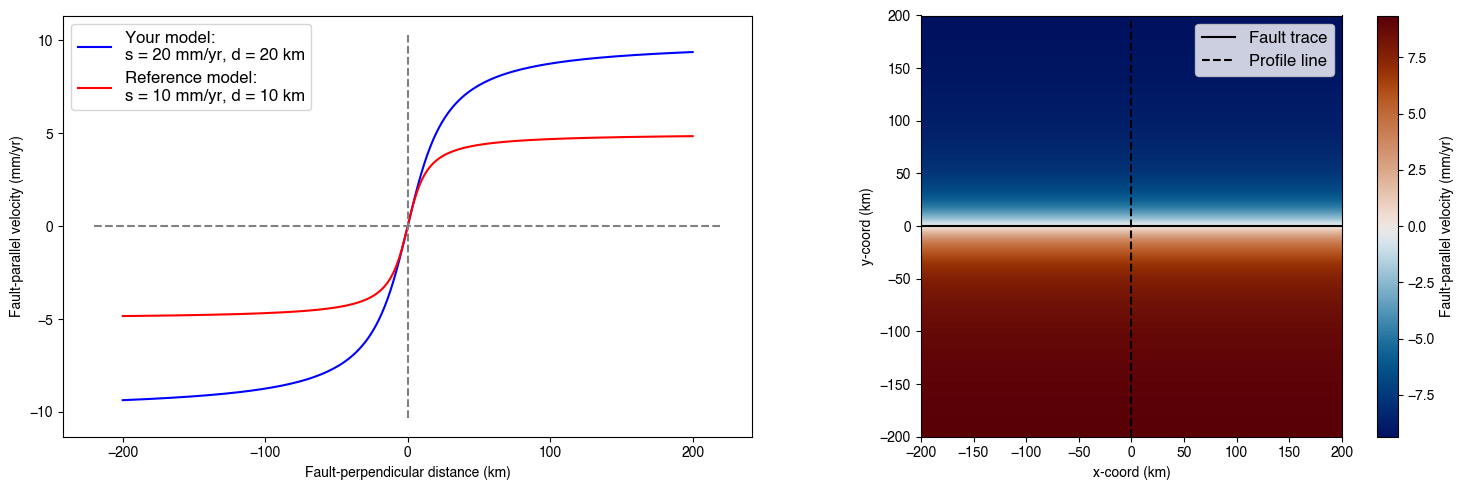

In [2]:
# set interseismic fault slip rate, s, and locking depth, d
#####################################
s = 20 # mm/yr          
d = 20 # km             
#####################################

# set up x coords (fault-perpendicular distances)
xmin, xmax, xint = -200, 200, 2 # km
x = np.arange(xmin, xmax+xint, xint)

# run the screw dislocation model. The 0 is just a static offset which we can ignore for now.
# We convert all units into SI (metres) so that they are consistent.
v = lib.screw_disc(x*1000, s/1000, d*1000, 0)

# we'll also generate a model at s = 10 mm/yr and d = 10 km as a reference solution
v_ref = lib.screw_disc(x*1000, 10/1000, 10*1000, 0)

# expand into 2D, assuming our fault strikes East-West
v_grid = np.tile(v, (len(x),1)).T


# Plot the result
# Let's break this first plotting section down

# create a figure and axes for our plot
fig, axs = plt.subplots(1,2,figsize=(15,5))

# plot the model velocities as a line to the first axes/subplot
axs[0].plot(x, v*1000, color="blue", label='Your model: \ns = ' + str(s) + ' mm/yr, d = ' + str(d) + ' km') 

# plot the reference model
axs[0].plot(x, v_ref*1000, color="red", label='Reference model: \ns = 10 mm/yr, d = 10 km')

# draw dashed lines at x=0 (the fault trace) and at y=0
axs[0].plot([0, 0],[axs[0].get_ylim()[0], axs[0].get_ylim()[1]], color='grey', linestyle='dashed')
axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]], [0, 0], color='grey', linestyle='dashed')

# add a legend
axs[0].legend(fontsize=12)

# set labels for the x and y axes
axs[0].set_xlabel('Fault-perpendicular distance (km)')
axs[0].set_ylabel('Fault-parallel velocity (mm/yr)')


# colour plot of our 2D velocities, now on our second axes/subplot
im = axs[1].imshow(v_grid*1000, extent=[xmin, xmax, xmin, xmax], cmap=cm.vik)

# add a labeled colour bar
plt.colorbar(im, ax=axs[1], label="Fault-parallel velocity (mm/yr)")

# add the fault as a solid line
axs[1].plot([xmin, xmax], [0, 0], color='black', label='Fault trace') 

# add the profile as a dashed line
axs[1].plot([0, 0],[xmin, xmax], color='black', linestyle='dashed', label="Profile line")

# add legend
axs[1].legend(fontsize=12)

# set labels for the x and y axes
axs[1].set_xlabel('x-coord (km)')
axs[1].set_ylabel('y-coord (km)')


# this alters subplot spacing
fig.tight_layout()

# display the plot
plt.show()

The left plot shows our simple 1D screw dislocation model. The right shows this model expanded to 2D, assuming that our fault strikes from East to West. The fault-parallel velocities are also East-West velocities in this setup.

While these fault-parallel velocities are what we want for modelling a fault, they're not what we directly measure with InSAR. SAR satellites such as Sentinel-1 look down at the ground with an incidence angle, $\theta$, of around 31-46&deg;. This angle changes through our scene. InSAR is also only capable of measuring displacements towards and away from the satellite. The result of these two factors is that InSAR measures only a component of the observed deformation projected into the satellite's line-of-sight (LOS), and a single look direction cannot differentiate between different components of displacement.

<img src="figures/incAngle.png" style="float: centre;" width="300"/>

*Figure 4: Schematic diagram of satellite incidence angle, $\theta$, measured between the vertical (dashed black line) and the satellite line-of-sight (blue arrow).*

Let's apply a line-of-sight projection to our signals and see what effect this has on the velocities.

The interseismic_lib includes a function to make a grid of incidence angles between a minimum and maximum value, rotated by the satellite heading. Remember that the Sentinel-1 satellites are side looking, so our incidence angles will change at 90&deg; to the satellite heading.

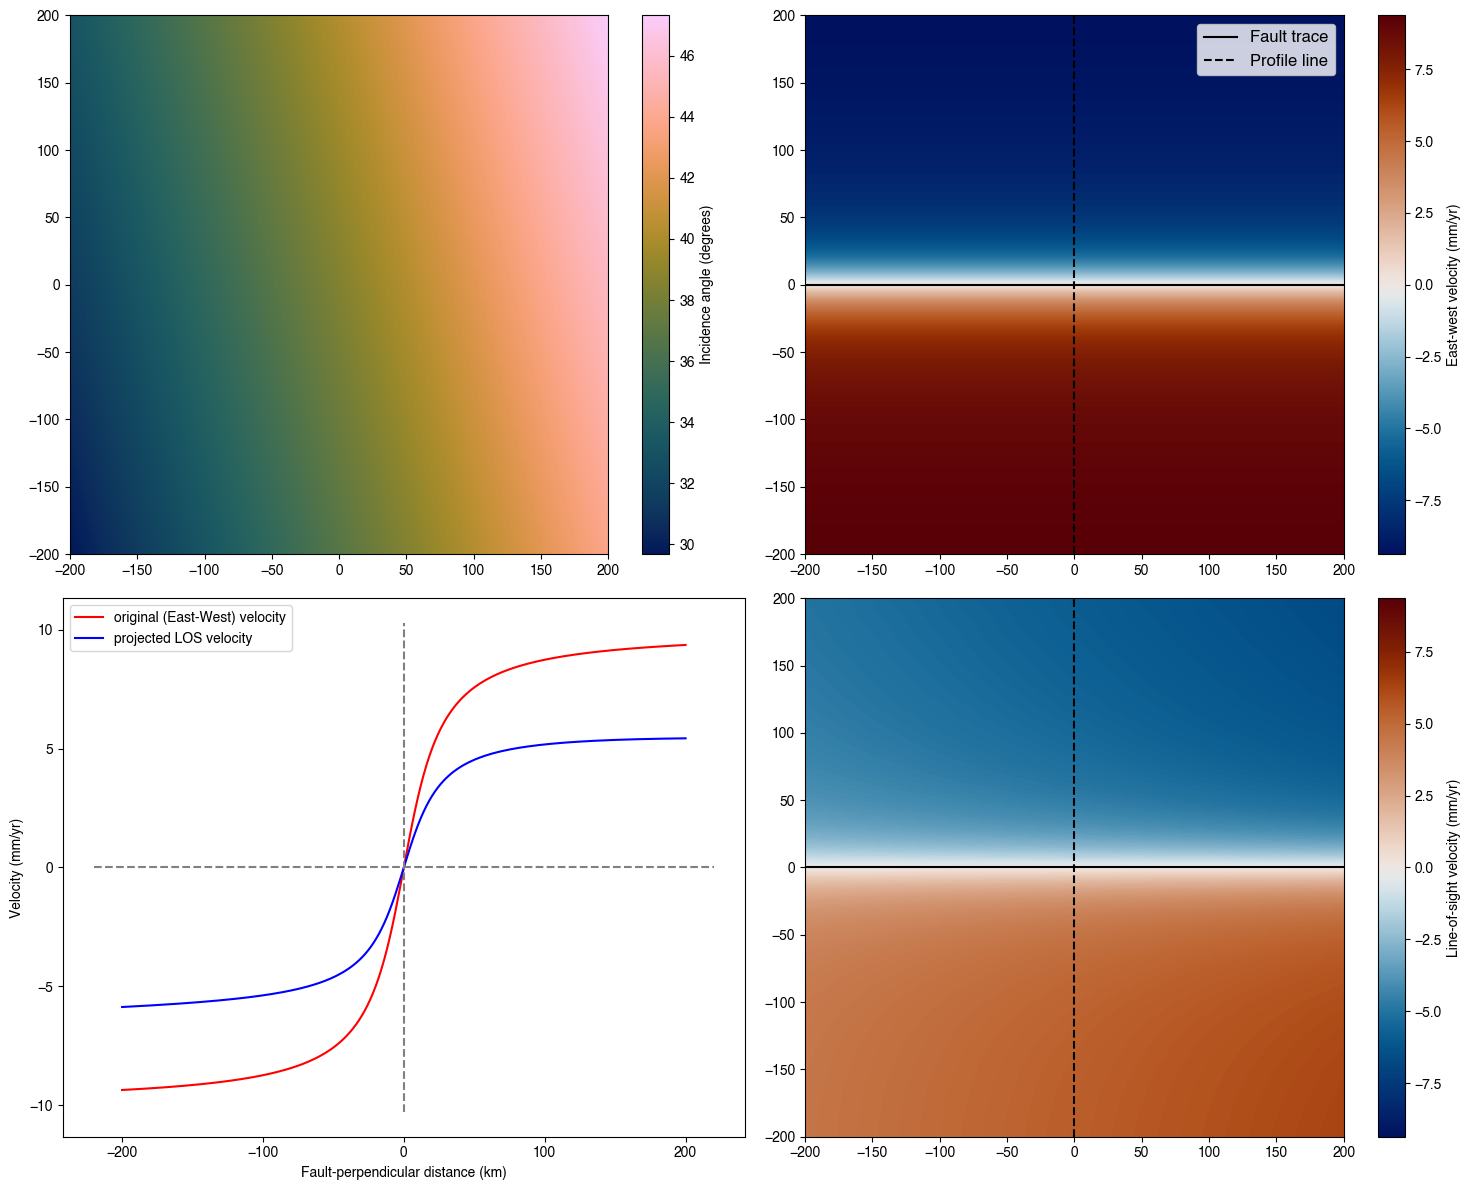

In [3]:
# heading (-14 for ascending, -166 for descending), minimum incidence angle, and maximum incidence angle
#####################################
heading = -14 # degrees
inc_min, inc_max = 31, 46 # degrees
#####################################

# create grids of these angles
heading_grid = np.ones(v_grid.shape) * heading
inc_grid = lib.gen_inc(inc_min, inc_max, heading, x, x)

# projection from east-west to los
e2los = np.cos(np.deg2rad(heading_grid)) * np.sin(np.deg2rad(inc_grid))
v_grid_los = v_grid * e2los

# plot 
fig, axs = plt.subplots(2,2,figsize=(15,12))

# get colour limits for grids
cmin, cmax = np.amin(v_grid*1000), np.amax(v_grid*1000)

# incidence angle grid
im = axs[0,0].imshow(inc_grid, extent=[xmin, xmax, xmin, xmax], cmap=cm.batlow)
plt.colorbar(im, ax=axs[0,0], label="Incidence angle (degrees)")

# East-west velocity grid
im = axs[0,1].imshow(v_grid*1000, extent=[xmin, xmax, xmin, xmax], cmap=cm.vik, vmin=cmin, vmax=cmax)
plt.colorbar(im, ax=axs[0,1], label="East-west velocity (mm/yr)")
axs[0,1].plot([xmin, xmax], [0, 0], color='black', label='Fault trace') 
axs[0,1].plot([0, 0],[xmin, xmax], color='black', linestyle='dashed', label="Profile line")
axs[0,1].legend(fontsize=12)

# 1D models
axs[1,0].plot(x, v*1000, color='red', label='original (East-West) velocity')
axs[1,0].plot(x, v_grid_los[:,np.argmin(np.abs(x))]*1000, color='blue', label='projected LOS velocity')
axs[1,0].plot([0, 0],[axs[1,0].get_ylim()[0], axs[1,0].get_ylim()[1]], color='grey', linestyle='dashed')
axs[1,0].plot([axs[1,0].get_xlim()[0], axs[1,0].get_xlim()[1]], [0, 0], color='grey', linestyle='dashed')
axs[1,0].set_xlabel('Fault-perpendicular distance (km)')
axs[1,0].set_ylabel('Velocity (mm/yr)')
axs[1,0].legend()

# Line-of-sight velocity grid
im = axs[1,1].imshow(v_grid_los*1000, extent=[xmin, xmax, xmin, xmax], cmap=cm.vik, vmin=cmin, vmax=cmax)
plt.colorbar(im, ax=axs[1,1], label="Line-of-sight velocity (mm/yr)")
axs[1,1].plot([xmin, xmax], [0, 0], color='black')
axs[1,1].plot([0, 0],[xmin, xmax], color='black', linestyle='dashed')

plt.tight_layout()
plt.show()

We can see that not only does the overall signal get smaller, but it also changes across the scene because of the varying incidence angle of the satellite.

Now that we've explored how a screw dislocation model might look in InSAR, we'll move on to applying the model to real world data.

## 2. Load the input time-series

We'll begin by loading in our LiCSBAS outputs (you generated the equivalent outputs in the LiCSBAS practicals). These have been renamed to include the frame name for clarity. The _asc and _desc tags in the variable names indicate the ascending or descending frame.

**vel_file** - file containing the LOS velocities (found in TS_GEOCml10/results/vel).

**par_file** - parameter file which contains the geographic location of the data, along with the size in x and y (found in GEOCml##).

**E/N/U_file** - unit vector components, which basically tell us how to go from the satellite LOS to East, North, and Up. We need these to perform the velocity decomposition later.

In [4]:
# setup file names
asc = '087A_04904_121313'
desc = '167D_04884_131212'

vel_file_asc = Path('data/' + asc + '.vel.mskd')
par_file_asc = Path('data/' + asc + '.par')
E_file_asc = Path('data/' + asc + '.E')
N_file_asc = Path('data/' + asc + '.N')
U_file_asc = Path('data/' + asc + '.U')

vel_file_desc = Path('data/' + desc + '.vel.mskd')
par_file_desc = Path('data/' + desc + '.par')
E_file_desc = Path('data/' + desc + '.E')
N_file_desc = Path('data/' + desc + '.N')
U_file_desc = Path('data/' + desc + '.U')

# read array dimensions from par file
width_asc = int(lib.get_par(par_file_asc,'width'))
length_asc = int(lib.get_par(par_file_asc,'nlines'))

width_desc = int(lib.get_par(par_file_desc,'width'))
length_desc = int(lib.get_par(par_file_desc,'nlines'))

# get corner positions
corner_lat_asc = float(lib.get_par(par_file_asc,'corner_lat'))
corner_lon_asc = float(lib.get_par(par_file_asc,'corner_lon'))

corner_lat_desc = float(lib.get_par(par_file_desc,'corner_lat'))
corner_lon_desc = float(lib.get_par(par_file_desc,'corner_lon'))

# get post spacing (distance between velocity measurements)
post_lat_asc = float(lib.get_par(par_file_asc,'post_lat'))
post_lon_asc = float(lib.get_par(par_file_asc,'post_lon'))

post_lat_desc = float(lib.get_par(par_file_desc,'post_lat'))
post_lon_desc = float(lib.get_par(par_file_desc,'post_lon'))

# calculate grid spacings
lat_asc = corner_lat_asc + post_lat_asc*np.arange(1,length_asc+1) - post_lat_asc/2
lon_asc = corner_lon_asc + post_lon_asc*np.arange(1,width_asc+1) - post_lon_asc/2

lat_desc = corner_lat_desc + post_lat_desc*np.arange(1,length_desc+1) - post_lat_desc/2
lon_desc = corner_lon_desc + post_lon_desc*np.arange(1,width_desc+1) - post_lon_desc/2

# load in velocities
vel_asc = np.fromfile(vel_file_asc, dtype='float32').reshape((length_asc, width_asc))
vel_desc = np.fromfile(vel_file_desc, dtype='float32').reshape((length_desc, width_desc))

# load in unit vectors
E_asc = np.fromfile(E_file_asc, dtype='float32').reshape((length_asc, width_asc))
N_asc = np.fromfile(N_file_asc, dtype='float32').reshape((length_asc, width_asc))
U_asc = np.fromfile(U_file_asc, dtype='float32').reshape((length_asc, width_asc))

E_desc = np.fromfile(E_file_desc, dtype='float32').reshape((length_desc, width_desc))
N_desc = np.fromfile(N_file_desc, dtype='float32').reshape((length_desc, width_desc))
U_desc = np.fromfile(U_file_desc, dtype='float32').reshape((length_desc, width_desc))

# load the frame polygons for plotting
poly_asc = np.loadtxt(Path('data/' + asc + '.poly'))
poly_desc = np.loadtxt(Path('data/' + desc + '.poly'))

# load the naf fault trace
fault_trace = np.loadtxt(Path('data/naf_trace.xy'))

print('Files loaded.')
print('Size of ascending velocity:')
print(vel_asc.shape)
print('Size of descending velocity:')
print(vel_desc.shape)

print('Limits of ascending (lon, lat):')
print(np.amin(lon_asc), np.amax(lon_asc), np.amin(lat_asc), np.amax(lat_asc))
print('Limits of descending (lon, lat):')
print(np.amin(lon_desc), np.amax(lon_desc), np.amin(lat_desc), np.amax(lat_desc))

Files loaded.
Size of ascending velocity:
(263, 353)
Size of descending velocity:
(268, 356)
Limits of ascending (lon, lat):
31.416388896049998 34.936386115249995 39.657224273749996 42.277222203950004
Limits of descending (lon, lat):
32.249444496049996 35.799441691549994 39.85694651325 42.526944403950004


Next, we'll plot the velocities to make sure they've loaded in correctly. The trace of the NAF will be plotted as a red line.

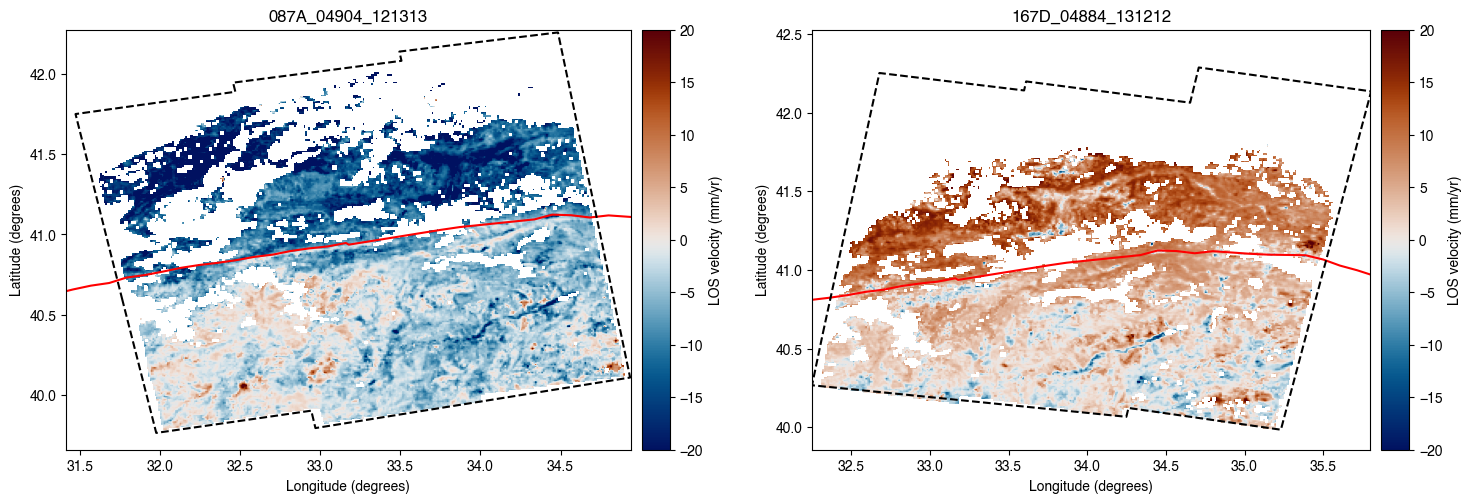

In [5]:
# plot input vels
fig, axs = plt.subplots(1,2,figsize=(15,5))

# plot the ascending velocities, saturating the colour palette from -20 to 20 mm/yr.
im = axs[0].imshow(vel_asc, extent=[np.amin(lon_asc), np.amax(lon_asc), np.amin(lat_asc), np.amax(lat_asc)], \
                   cmap=cm.vik, vmin=-20, vmax=20)

# add the NAF fault trace
axs[0].plot(fault_trace[:,0], fault_trace[:,1], color="red")

# add the frame polygon
axs[0].plot(poly_asc[:,0], poly_asc[:,1], color="black", linestyle='dashed')

# display the colorbar, this "divider" section is to scale the colorbar size to the plot
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='LOS velocity (mm/yr)')

# set the title
axs[0].set_title('087A_04904_121313')

# set the x and y limits of the plot
axs[0].set_xlim(np.amin(lon_asc), np.amax(lon_asc))
axs[0].set_ylim(np.amin(lat_asc), np.amax(lat_asc))

# label the x and y axes
axs[0].set_xlabel('Longitude (degrees)')
axs[0].set_ylabel('Latitude (degrees)')

# repeat for the descending velocities
im = axs[1].imshow(vel_desc, extent=[np.amin(lon_desc), np.amax(lon_desc), np.amin(lat_desc), np.amax(lat_desc)], \
                   cmap=cm.vik, vmin=-20, vmax=20)
axs[1].plot(fault_trace[:,0], fault_trace[:,1], color="red")
axs[1].plot(poly_desc[:,0], poly_desc[:,1], color="black", linestyle='dashed')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='LOS velocity (mm/yr)')
axs[1].set_title('167D_04884_131212')
axs[1].set_xlim(np.amin(lon_desc), np.amax(lon_desc))
axs[1].set_ylim(np.amin(lat_desc), np.amax(lat_desc))
axs[1].set_xlabel('Longitude (degrees)')
axs[1].set_ylabel('Latitude (degrees)')

# show the plot
fig.tight_layout()
plt.show()

By default, LiCSBAS sets motion towards the satellite as positive, and motion away from the satellite as negative. These velocities are relative to a LiCSBAS-selected reference point within each frame.

We can already see a change a the LOS velocites across the fault in both maps. To investigate further, lets take a profile across the fault in the ascending velocities.

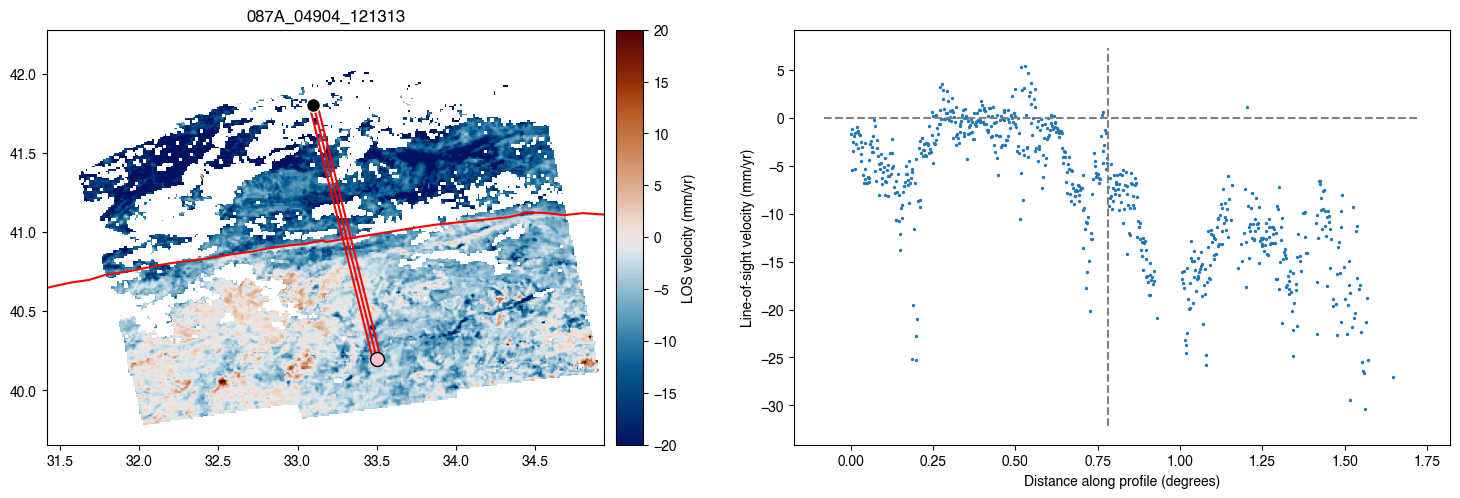

In [6]:
# start and end coordinates of the profile, and extra parameters
#####################################
prof_start = (33.5, 40.2)
prof_end = (33.1, 41.8)
prof_params = {
    "nbins": 100, # number of bins to split the profile into
    "width": 0.05 # total width of the profile in degrees (1 degree ~ 110 km)
}
#####################################

# run the profiler, the outputs are as follows:
# - bin_val = mean value of each bin
# - prof_bin_mids = distance along the profile to the middle of each bin
# - points_val = every velocity within the profile
# - points_dist = distance along the profile to every point within the profile
# - points_poly = polygon that defines the profile
bin_val, prof_bin_mids, points_val, points_dist, points_poly \
    = lib.profile_data(lon_asc,lat_asc,vel_asc,prof_start,prof_end,prof_params)

# calculate profile-fault intersection angle
intersect_dist, intersect_angle = lib.profile_fault_intersection(prof_start,prof_end,fault_trace)

# plot the ascending velocities and the profiled data
fig, axs = plt.subplots(1,2,figsize=(15,5))

# ascending velocity map
im = axs[0].imshow(vel_asc, extent=[np.amin(lon_asc), np.amax(lon_asc), np.amin(lat_asc), np.amax(lat_asc)], \
                   cmap=cm.vik, vmin=-20, vmax=20)
axs[0].plot(fault_trace[:,0], fault_trace[:,1], color="red")
axs[0].plot([prof_start[0], prof_end[0]], [prof_start[1], prof_end[1]], color="red")
axs[0].plot(points_poly[:,0],points_poly[:,1], color="red")
axs[0].scatter(prof_start[0],prof_start[1], s=100, color='pink', edgecolor='black', zorder=3)
axs[0].scatter(prof_end[0],prof_end[1], s=100, color='black', edgecolor='white', zorder=3)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='LOS velocity (mm/yr)')
axs[0].set_title('087A_04904_121313')
axs[0].set_xlim(np.amin(lon_asc), np.amax(lon_asc))
axs[0].set_ylim(np.amin(lat_asc), np.amax(lat_asc))

# velocities projected onto profile
axs[1].scatter(points_dist, points_val, s=2)
axs[1].plot([intersect_dist, intersect_dist],[axs[1].get_ylim()[0], axs[1].get_ylim()[1]], color='grey', linestyle='dashed')
axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]], [0, 0], color='grey', linestyle='dashed')
axs[1].set_xlabel("Distance along profile (degrees)")
axs[1].set_ylabel("Line-of-sight velocity (mm/yr)")

fig.tight_layout()
plt.show()

The left plot shows our velocity map. The pink dot marks the start of the profile, and the black dot marks the end. The three red line between these show the main profile line and the extents of the profile width.

Our profiled velocities are shown on the right. These are projected onto the profile line, and so are given at distance along the profile from prof_start, which is located at 0 distance. The units of distance are the same as those for the profiled data set. The vertical dashed line marks where the profile line intersects the fault trace of the NAF.

While the profiled velocities are a little noisy, you should be able to see an overall change in velocity across the fault.

## 3. Decompose the line-of-sight velocities into fault-parallel and vertical

Equation 1 requires fault-parallel velocities, while ours are currently in the satellite LOS.
We can estimate fault-parallel velocities by decomposing our LOS velocities into fault-parallel, fault-perpendicular, and vertical velocities.
This is done by solving a linear system of equations between our InSAR velocities ($V_{asc}$ and $V_{desc}$) and our component velocities.
We convert between the two using the radar incidence angle, $\theta$, and the azimuth of the along-track satellite heading, $\alpha$, and the strike of our fault, $\gamma$. Both $\theta$ and $\alpha$ vary pixel-by-pixel.

First, let's look at how we would decompose our LOS velocities into East ($V_E$), North ($V_N$), and vertical ($V_U$) velocities:
\begin{equation}
    \begin{bmatrix} V_{asc} \\ V_{desc} \end{bmatrix} = \begin{bmatrix} sin(\theta_{asc})cos(\alpha_{asc}) & sin(\theta_{asc})sin(\alpha_{asc}) & -cos(\theta_{asc}) \\ sin(\theta_{desc})cos(\alpha_{desc}) & sin(\theta_{desc})sin(\alpha_{desc}) & -cos(\theta_{desc}) \end{bmatrix} \begin{bmatrix} V_E \\ V_N \\ V_U \end{bmatrix}
    \qquad \qquad (2)
\end{equation}

We calcualte fault-parallel ($V_{para}$) and fault-perpendicular ($V_{perp}$) velocities as a sum of relavent components of $V_E$ and $V_N$, including an extra term to account for the strike of the fault measured clockwise from North: 

\begin{equation}
    \begin{bmatrix} V_{asc} \\ V_{desc} \end{bmatrix} = \begin{bmatrix} \begin{pmatrix} sin(\gamma)sin(\theta_{asc})cos(\alpha_{asc})\\+ cos(\gamma)sin(\theta_{asc})sin(\alpha_{asc}) \end{pmatrix} & \begin{pmatrix} cos(\gamma)sin(\theta_{asc})cos(\alpha_{asc})\\+ sin(\gamma)sin(\theta_{asc})sin(\alpha_{asc}) \end{pmatrix} & -cos(\theta_{asc}) \\ \begin{pmatrix} sin(\gamma)sin(\theta_{desc})cos(\alpha_{desc})\\+ cos(\gamma)sin(\theta_{desc})sin(\alpha_{desc}) \end{pmatrix} & \begin{pmatrix} cos(\gamma)sin(\theta_{desc})cos(\alpha_{desc})\\+ sin(\gamma)sin(\theta_{desc})sin(\alpha_{desc}) \end{pmatrix} & -cos(\theta_{desc}) \end{bmatrix} \begin{bmatrix} V_{para} \\ V_{perp} \\ V_U \end{bmatrix}
    \qquad \qquad (3)
\end{equation}

In both cases, we have three unknowns and only two data sets, making this an underdetermined system.
Given that the amount of data available to us is fixed, we need to reduce the number of component velocities we want to estimate by one so that we can solve for the remaining two.
We'll assume that $V_{perp}$ is zero so that we can solve for $V_{para}$ and $V_U$. We choose $V_{perp}$ because we expect the dominant signal to be strike-slip motion on the East-West striking NAF, producing a small North-South component which the Sentinel-1 satellites are particularly insensitive to because of their near-polar orbit.

We can now rewrite Equation 3:

\begin{equation}
    \begin{bmatrix} V_{asc} \\ V_{desc} \end{bmatrix} = \begin{bmatrix} sin(\gamma)sin(\theta_{asc})cos(\alpha_{asc})+cos(\gamma)sin(\theta_{asc})sin(\alpha_{asc}) & -cos(\theta_{asc}) \\ sin(\gamma)sin(\theta_{desc})cos(\alpha_{desc})+cos(\gamma)sin(\theta_{desc})sin(\alpha_{desc}) & -cos(\theta_{desc}) \end{bmatrix} \begin{bmatrix} V_{para} \\ V_U \end{bmatrix}
    \qquad \qquad (4)
\end{equation}

where $V_{asc}$ and $V_{desc}$ are the LOS velocities, $\theta$ is the radar incidence angle, and $\alpha$ is the azimuth of the along-track satellite heading. The conversion from LOS to fault-parallel can be simplified to $sin(\theta)sin(\alpha + \gamma)$, however, we only have the unit component vectors available, not the individual values of $\theta$ and $\alpha$, so we'll stick with Equation 4.

Currently, these velocities are on two slightly different grids. We need to unify the grids so that we can perform the velocity decomposition for shared points.

In [7]:
# limits and intervals for new grid
lon_min = np.amin([lon_asc[0], lon_desc[0]])
lon_max = np.amax([lon_asc[-1], lon_desc[-1]])
lon_int = np.amin([post_lon_asc, post_lon_desc])
lon_regrid = np.arange(lon_min,lon_max+lon_int,lon_int)

lat_max = np.amax([lat_asc[0], lat_desc[0]])
lat_min = np.amin([lat_asc[-1], lat_desc[-1]])
lat_int = np.absolute(np.amin([post_lat_asc, post_lat_desc]))
lat_regrid = np.arange(lat_min,lat_max+lat_int,lat_int)

xx_regrid, yy_regrid = np.meshgrid(lon_regrid, lat_regrid[::-1])
coords_regrid = np.transpose(np.vstack((xx_regrid.flatten(),yy_regrid.flatten())))

# interpolate velocities onto this new grid
xx_asc, yy_asc = np.meshgrid(lon_asc, lat_asc)
vel_asc_regrid = interpolate.griddata((xx_asc.ravel(), yy_asc.ravel()), vel_asc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel()))
vel_asc_regrid = vel_asc_regrid.reshape((len(lat_regrid),len(lon_regrid)))

xx_desc, yy_desc = np.meshgrid(lon_desc, lat_desc)
vel_desc_regrid = interpolate.griddata((xx_desc.ravel(), yy_desc.ravel()), vel_desc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel()))
vel_desc_regrid = vel_desc_regrid.reshape((len(lat_regrid),len(lon_regrid)))

# interpolate the component vectors into the new grid
E_asc_regrid = interpolate.griddata((xx_asc.ravel(), yy_asc.ravel()), E_asc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))
N_asc_regrid = interpolate.griddata((xx_asc.ravel(), yy_asc.ravel()), N_asc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))
U_asc_regrid = interpolate.griddata((xx_asc.ravel(), yy_asc.ravel()), U_asc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))

E_desc_regrid = interpolate.griddata((xx_desc.ravel(), yy_desc.ravel()), E_desc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))
N_desc_regrid = interpolate.griddata((xx_desc.ravel(), yy_desc.ravel()), N_desc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))
U_desc_regrid = interpolate.griddata((xx_desc.ravel(), yy_desc.ravel()), U_desc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))

print('Regridding complete.')
print('Size of ascending velocity:')
print(vel_asc_regrid.shape)
print('Size of descending velocity:')
print(vel_desc_regrid.shape)

Regridding complete.
Size of ascending velocity:
(288, 440)
Size of descending velocity:
(288, 440)


Currently the two velocities fields are relative to their own reference pixels. We need to make this reference the same so that the velocities can be decomposed correctly. We'll define a reference window and use the mean of all the velocities within that area as the reference.

In [8]:
# define new reference pixel
ref_xmin, ref_xmax = 32.65, 32.85
ref_ymin, ref_ymax = 41.1, 41.2

# ref poly for plotting
ref_poly = np.array([[ref_xmin, ref_ymin],
           [ref_xmin, ref_ymax],
           [ref_xmax, ref_ymax],
           [ref_xmax, ref_ymin],
           [ref_xmin, ref_ymin]])

# get index
ind_xmin = np.argmin(np.absolute(lon_regrid-ref_xmin))
ind_xmax = np.argmin(np.absolute(lon_regrid-ref_xmax))
ind_ymin = np.argmin(np.absolute(lat_regrid-ref_ymin))
ind_ymax = np.argmin(np.absolute(lat_regrid-ref_ymax))

# get ref value
ref_val_asc = np.nanmean(vel_asc_regrid[ind_ymin:ind_ymax+1,ind_xmin:ind_xmax+1])
ref_val_desc = np.nanmean(vel_desc_regrid[ind_ymin:ind_ymax+1,ind_xmin:ind_xmax+1])

# set as new reference
vel_asc_regrid = vel_asc_regrid - ref_val_asc
vel_desc_regrid = vel_desc_regrid - ref_val_desc

print('Referencing complete.')
print('Mean value of reference for ascending = ' + str(round(ref_val_asc,3)) + ' mm/yr')
print('Mean value of reference for descending = ' + str(round(ref_val_desc,3)) + ' mm/yr')

Referencing complete.
Mean value of reference for ascending = -12.291 mm/yr
Mean value of reference for descending = 10.69 mm/yr


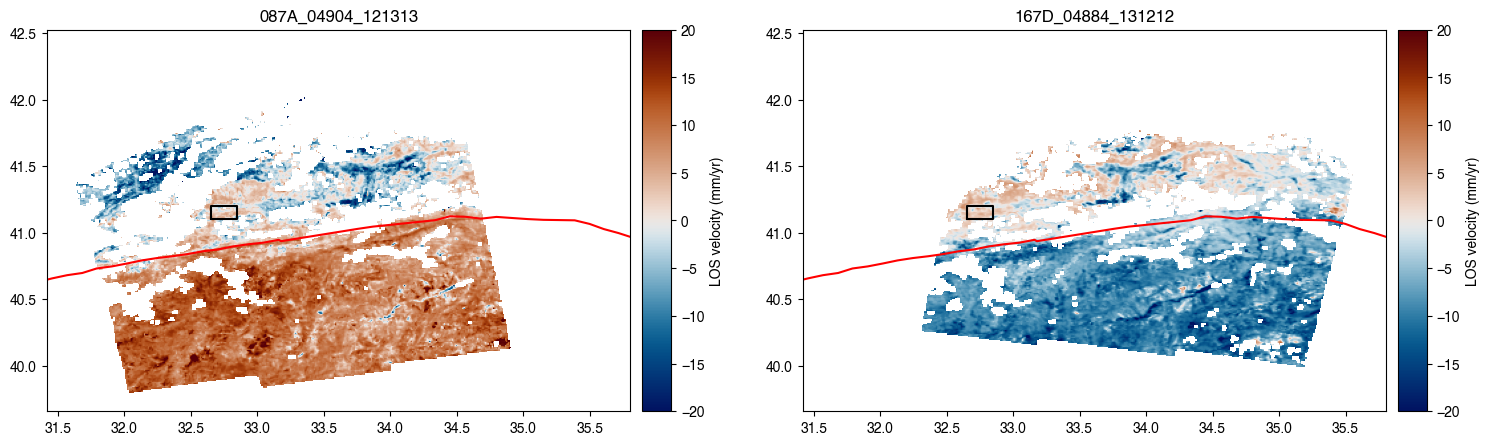

In [9]:
# plot the regridded velocities to make sure they're fine
fig, axs = plt.subplots(1,2,figsize=(15,10))

# ascending velocities
im = axs[0].imshow(vel_asc_regrid, extent=[lon_regrid[0], lon_regrid[-1], lat_regrid[0], lat_regrid[-1]], \
                   cmap=cm.vik, vmin=-20, vmax=20)
axs[0].plot(fault_trace[:,0], fault_trace[:,1], color="red")
axs[0].plot(ref_poly[:,0], ref_poly[:,1], color='black')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='LOS velocity (mm/yr)')
axs[0].set_title('087A_04904_121313')
axs[0].set_xlim(np.amin(lon_regrid), np.amax(lon_regrid))
axs[0].set_ylim(np.amin(lat_regrid), np.amax(lat_regrid))

# descending velocities
im = axs[1].imshow(vel_desc_regrid, extent=[lon_regrid[0], lon_regrid[-1], lat_regrid[0], lat_regrid[-1]], \
                   cmap=cm.vik, vmin=-20, vmax=20)
axs[1].plot(fault_trace[:,0], fault_trace[:,1], color="red")
axs[1].plot(ref_poly[:,0], ref_poly[:,1], color='black')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='LOS velocity (mm/yr)')
axs[1].set_title('167D_04884_131212')
axs[1].set_xlim(np.amin(lon_regrid), np.amax(lon_regrid))
axs[1].set_ylim(np.amin(lat_regrid), np.amax(lat_regrid))

fig.tight_layout(w_pad=3)
plt.show()

Now we'll run the decomposition for each pixel, assuming no correlation between pixels and a strike of 80&deg;.

In [10]:
# set strike
strike = 80
strike_E, strike_N = np.sin(np.deg2rad(strike)), np.cos(np.deg2rad(strike))

# pre-allocate
vel_para = np.zeros((len(lat_regrid), len(lon_regrid)))
vel_U = np.zeros((len(lat_regrid), len(lon_regrid)))

# loop through every pixel
for ii in np.arange(0,len(lat_regrid)):
    for jj in np.arange(0,len(lon_regrid)):
        
        # create the design matrix
        G = np.array([[strike_E*E_asc_regrid[ii,jj] + strike_N*N_asc_regrid[ii,jj], U_asc_regrid[ii,jj]], 
                      [strike_E*E_desc_regrid[ii,jj] + strike_N*N_desc_regrid[ii,jj], U_desc_regrid[ii,jj]]])
        
        # get the two velocities for this pixel
        d = np.array([[vel_asc_regrid[ii,jj], vel_desc_regrid[ii,jj]]]).T
        
        # solve the linear system for the Up and East velocities
        m = np.linalg.solve(G, d)
        
        # save to arrays
        vel_para[ii,jj] = m[0]
        vel_U[ii,jj] = m[1]
        
print('Velocity decomposition complete.')

Velocity decomposition complete.


Plot the decomposed velocities, including the frame polygons so that we can see how we only get the decomposed velocities in the overlap area, where we have both line-of-sights to work with.

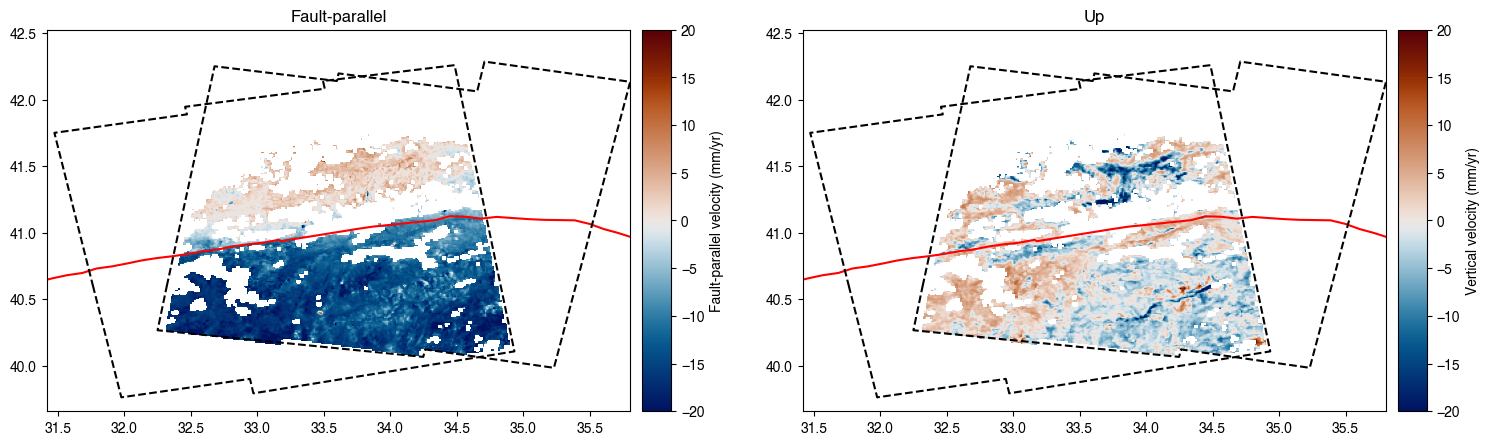

In [11]:
# plot the results
fig, axs = plt.subplots(1,2,figsize=(15,10))

# East velocities
im = axs[0].imshow(vel_para, extent=[lon_regrid[0], lon_regrid[-1], lat_regrid[0], lat_regrid[-1]], \
                   cmap=cm.vik, vmin=-20, vmax=20)
axs[0].plot(fault_trace[:,0], fault_trace[:,1], color="red")
axs[0].plot(poly_asc[:,0], poly_asc[:,1], color="black", linestyle='dashed')
axs[0].plot(poly_desc[:,0], poly_desc[:,1], color="black", linestyle='dashed')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='Fault-parallel velocity (mm/yr)')
axs[0].set_title('Fault-parallel')
axs[0].set_xlim(np.amin(lon_regrid), np.amax(lon_regrid))
axs[0].set_ylim(np.amin(lat_regrid), np.amax(lat_regrid))

# Up velocities
im = axs[1].imshow(vel_U, extent=[lon_regrid[0], lon_regrid[-1], lat_regrid[0], lat_regrid[-1]], \
                   cmap=cm.vik, vmin=-20, vmax=20)
axs[1].plot(fault_trace[:,0], fault_trace[:,1], color="red")
axs[1].plot(poly_asc[:,0], poly_asc[:,1], color="black", linestyle='dashed')
axs[1].plot(poly_desc[:,0], poly_desc[:,1], color="black", linestyle='dashed')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='Vertical velocity (mm/yr)')
axs[1].set_title('Up')
axs[1].set_xlim(np.amin(lon_regrid), np.amax(lon_regrid))
axs[1].set_ylim(np.amin(lat_regrid), np.amax(lat_regrid))

plt.tight_layout(w_pad=3)
plt.show()

## 4. Profile the fault-parallel velocities

We'll now profile our decomposed fault-parallel velocities to produce a dataset which we can then apply our screw dislocation model to. First, we need to project our lat-long coordinates into Universal Transverse Mercator (UTM) so that the profile distances are in metres and not degrees. After this projection, our velocities will no longer be on a regular grid, so we'll plot them using scatter instead of imshow.

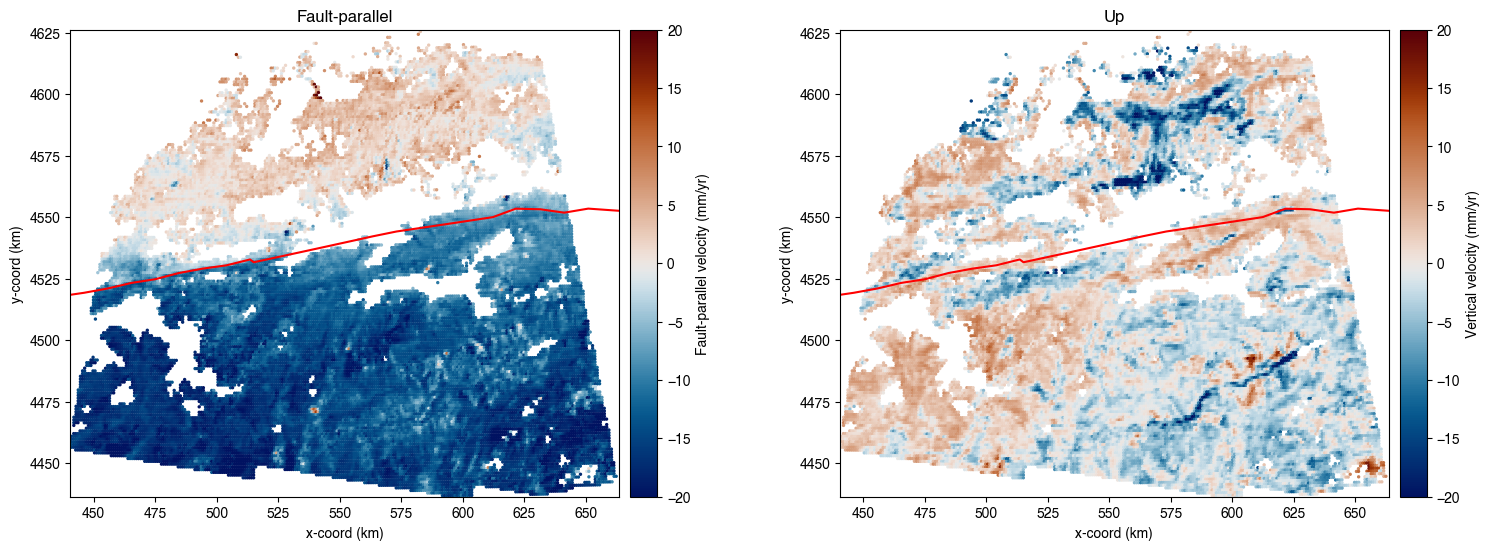

In [12]:
# Convert to UTM using gdal

# get the utm zone projection
utm_crs_list = pyproj.database.query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest = pyproj.aoi.AreaOfInterest(
        west_lon_degree  = np.amin(lon_regrid),
        south_lat_degree = np.amin(lat_regrid),
        east_lon_degree  = np.amax(lon_regrid),
        north_lat_degree = np.amax(lat_regrid),
    ),
)
utm_crs = pyproj.CRS.from_epsg(utm_crs_list[0].code)

# create transformer for LL to UTM
transformer = pyproj.Transformer.from_crs('epsg:4326', utm_crs)

# apply transform to our grids of lat long coordinates
xx_utm, yy_utm = transformer.transform(yy_regrid, xx_regrid)

# apply transform to fault trace
fault_trace_utm = fault_trace.copy()
fault_trace_utm[:,0], fault_trace_utm[:,1] = transformer.transform(fault_trace[:,1], fault_trace[:,0])

# convert utm metres to km (easier to work with for plotting)
xx_utm = xx_utm / 1000
yy_utm = yy_utm / 1000
fault_trace_utm = fault_trace_utm / 1000

# get new limits for plotting
val_ind_row, val_ind_col = np.where(~np.isnan(vel_U).all(axis=0))[0], np.where(~np.isnan(vel_U).all(axis=1))[0]
xlim = [xx_utm[-1,val_ind_row[0]], xx_utm[-1,val_ind_row[-1]]]
ylim = [yy_utm[val_ind_col[-1],0], yy_utm[val_ind_col[0],0]]

# replot with new coordinates
fig, axs = plt.subplots(1,2,figsize=(15,7))

# East velocities
im = axs[0].scatter(xx_utm.flatten(), yy_utm.flatten(), s=2, c=vel_para.flatten(), cmap=cm.vik, vmin=-20, vmax=20)
axs[0].plot(fault_trace_utm[:,0], fault_trace_utm[:,1], color="red")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='Fault-parallel velocity (mm/yr)')
axs[0].set_aspect('equal', 'box')
axs[0].set_title('Fault-parallel')
axs[0].set_xlabel('x-coord (km)')
axs[0].set_ylabel('y-coord (km)')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

# Up velocities
im = axs[1].scatter(xx_utm.flatten(), yy_utm.flatten(), s=2, c=vel_U.flatten(), cmap=cm.vik, vmin=-20, vmax=20)
axs[1].plot(fault_trace_utm[:,0], fault_trace_utm[:,1], color="red")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='Vertical velocity (mm/yr)')
axs[1].set_aspect('equal', 'box')
axs[1].set_title('Up')
axs[1].set_xlabel('x-coord (km)')
axs[1].set_ylabel('y-coord (km)')
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

fig.tight_layout(w_pad=5)
plt.show()

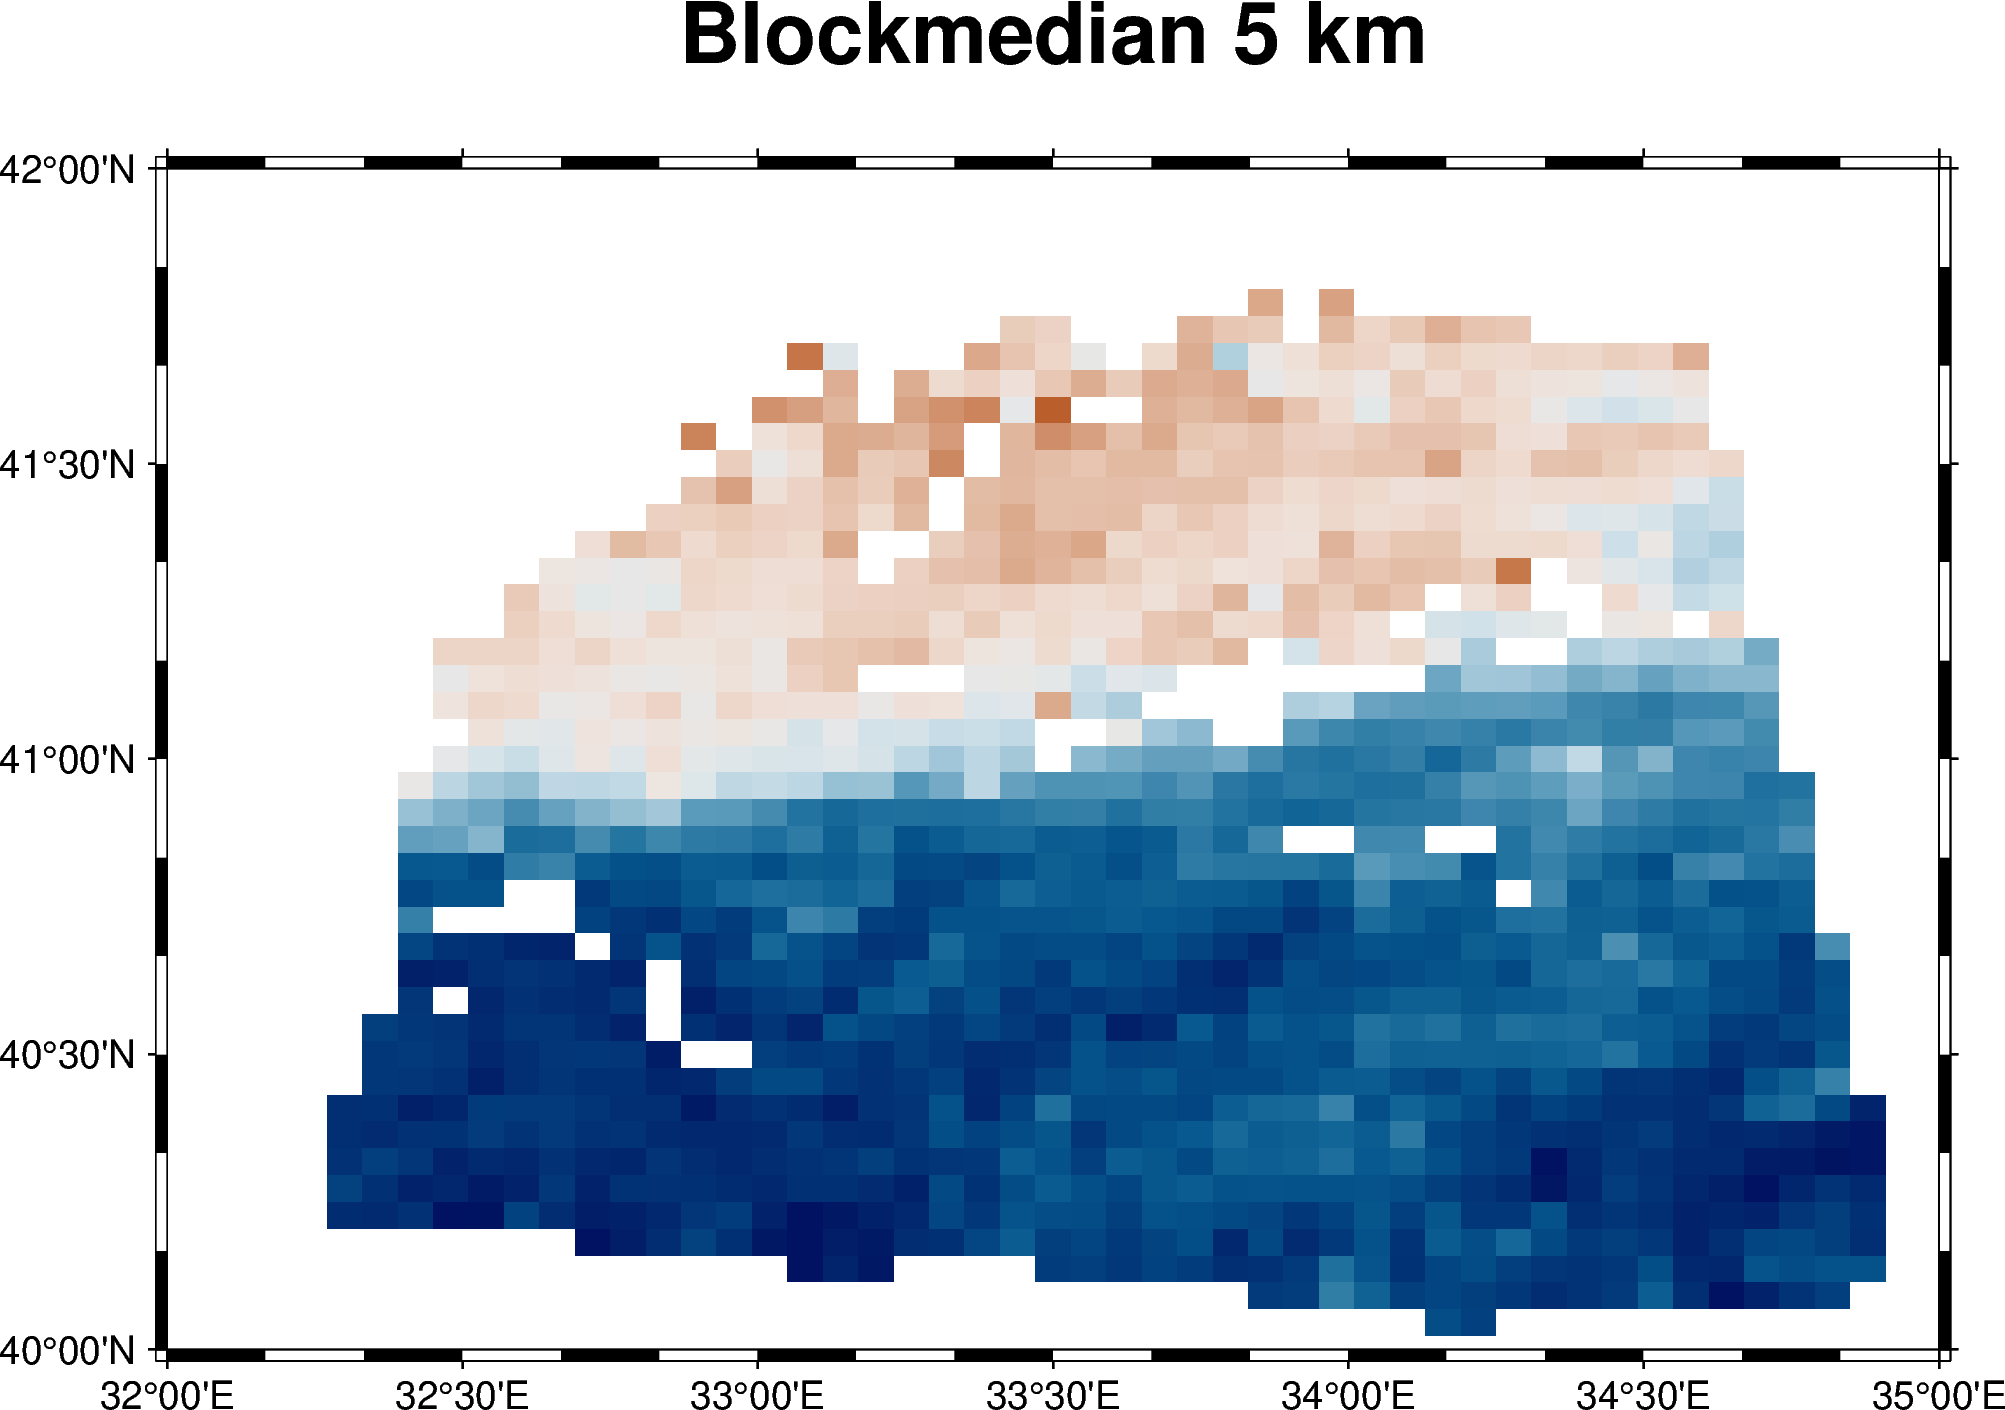

In [48]:
import pygmt
region="32/35/40/42"
spacing="5k" # spacing 10 arcminutes

# calculate block median
vel_para_median = pygmt.blockmedian(
    x=xx_regrid.flatten(), y=yy_regrid.flatten(), z=vel_para.flatten(), region=region, spacing=spacing
)

# convert to grid
vel_para_median_grd = pygmt.xyz2grd(data=vel_para_median, region=region, spacing=spacing)

# plot block median grid
fig = pygmt.Figure()
pygmt.makecpt(cmap="vik", series=[-20, 20])
fig.grdimage(
    grid=vel_para_median_grd,
    region=region,
    frame=["af", '+t"Blockmedian 5 km"'],
)
fig.show()

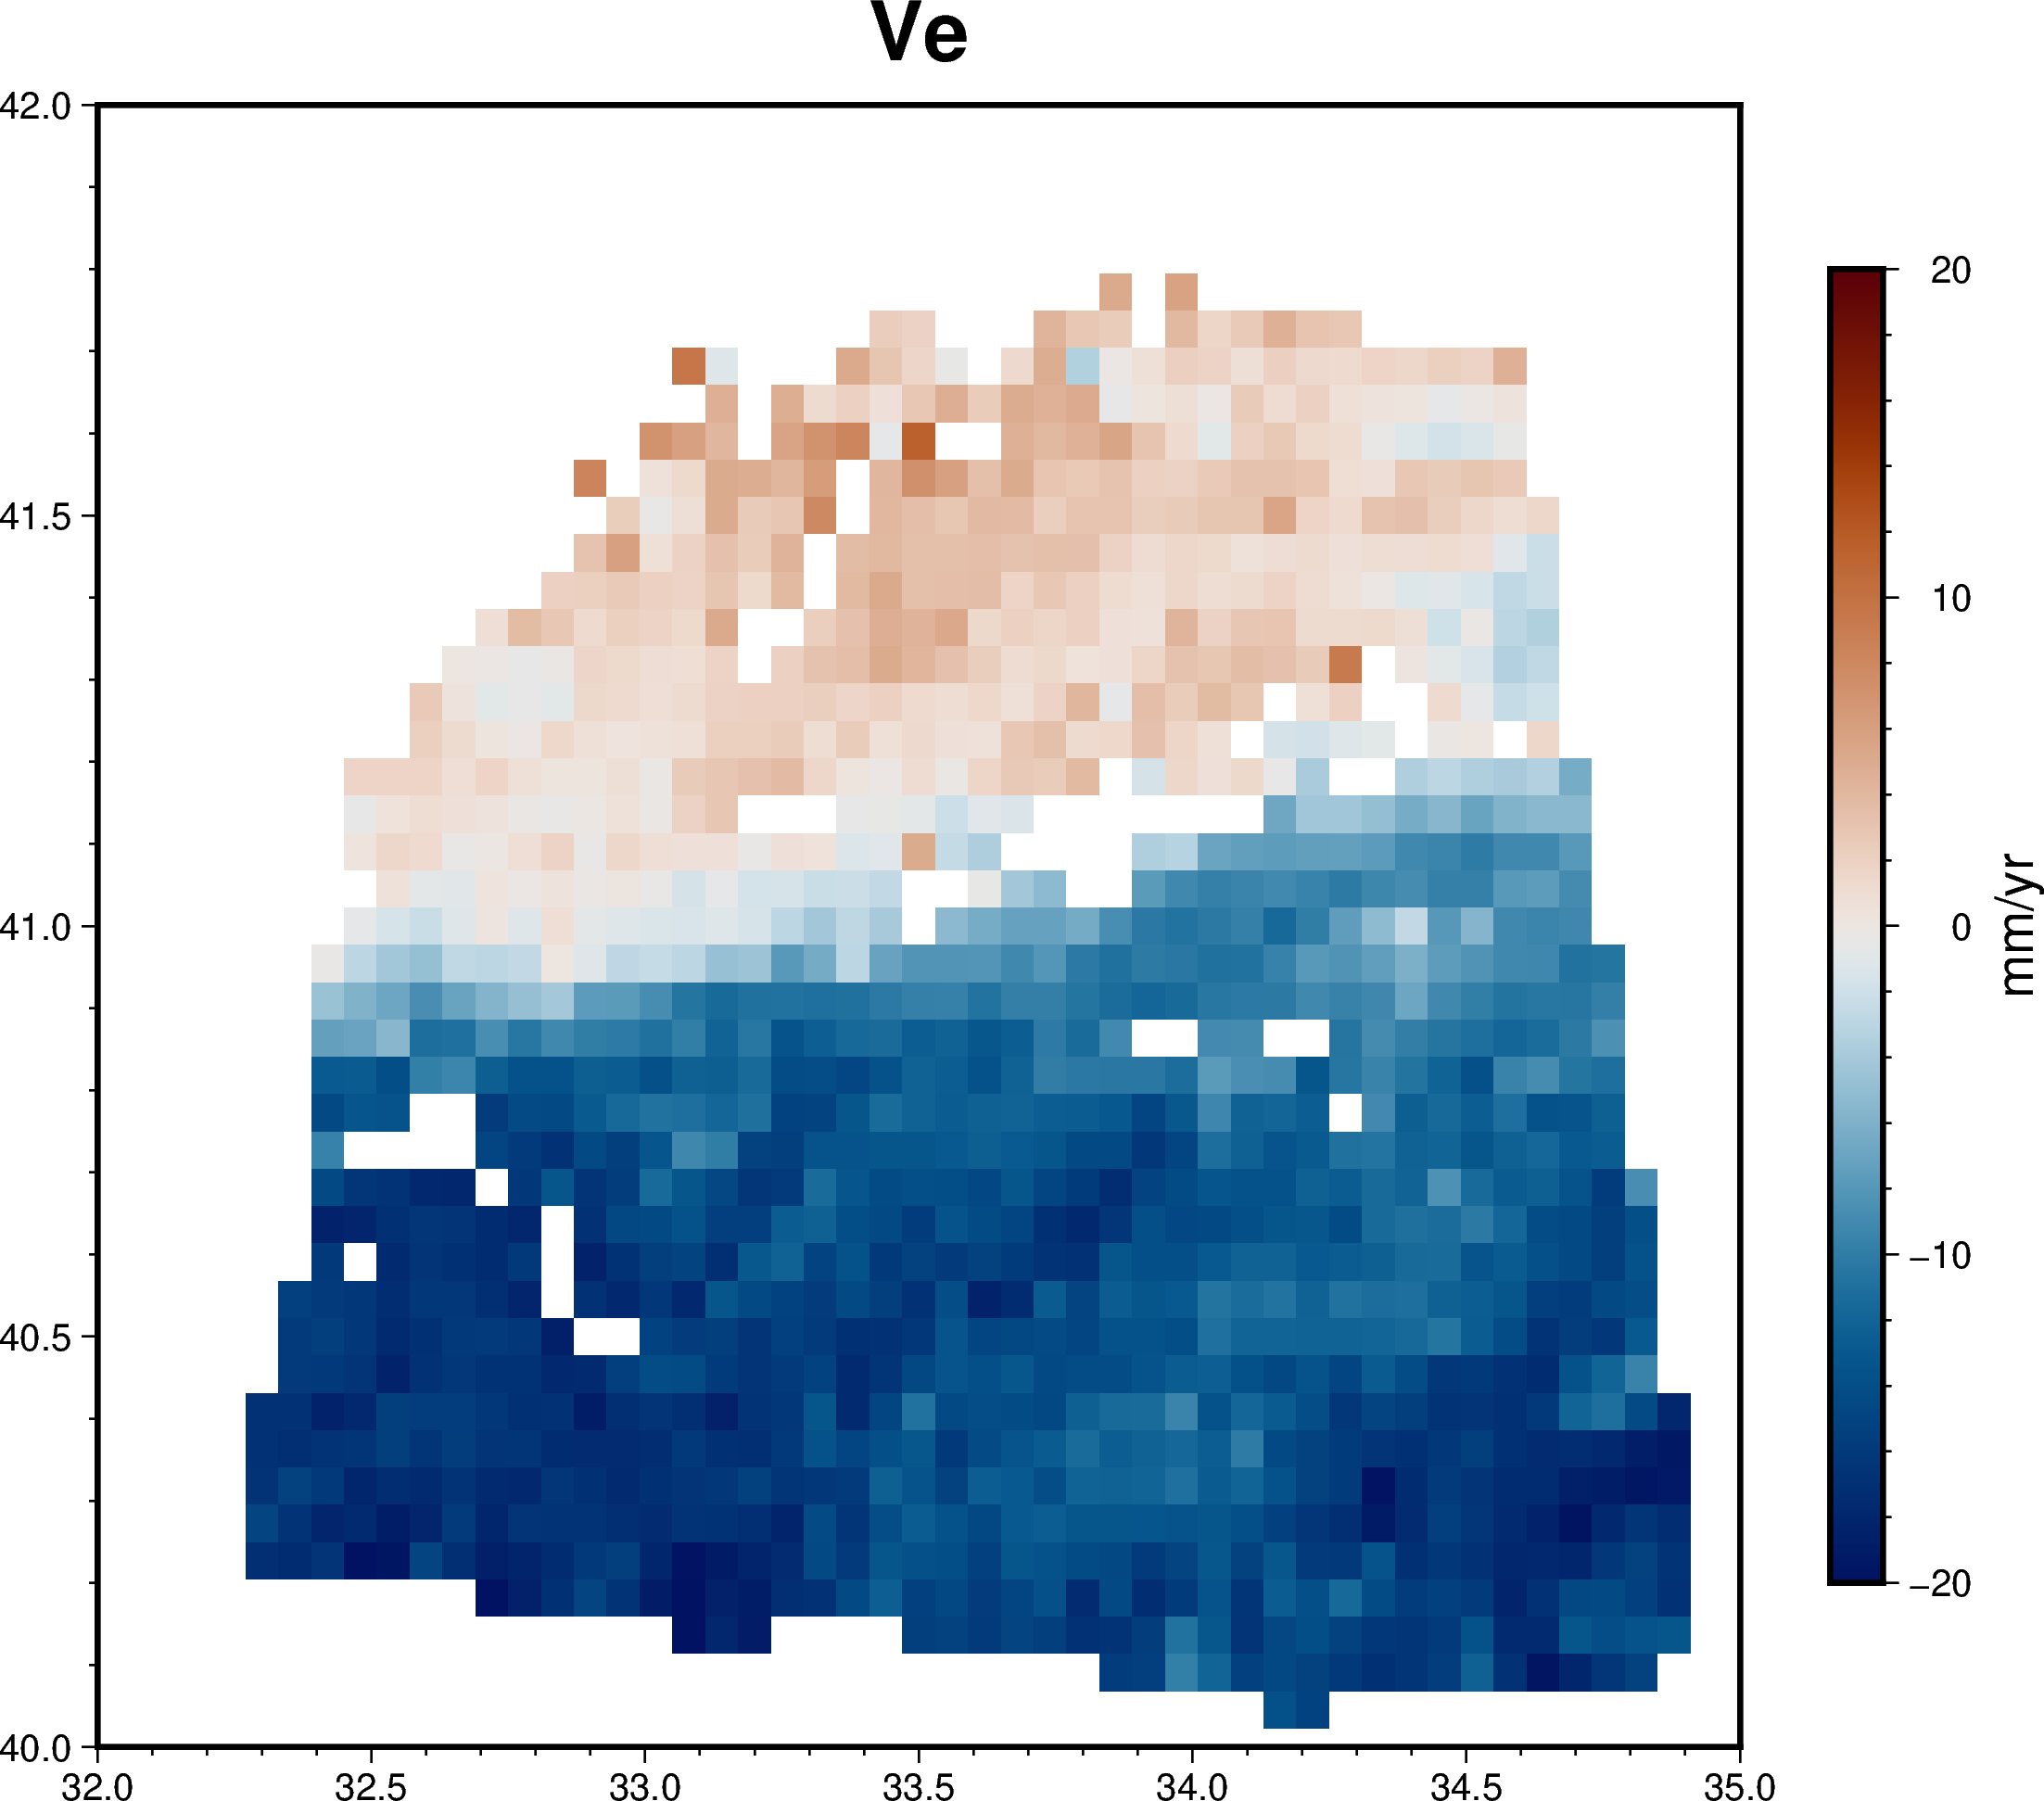

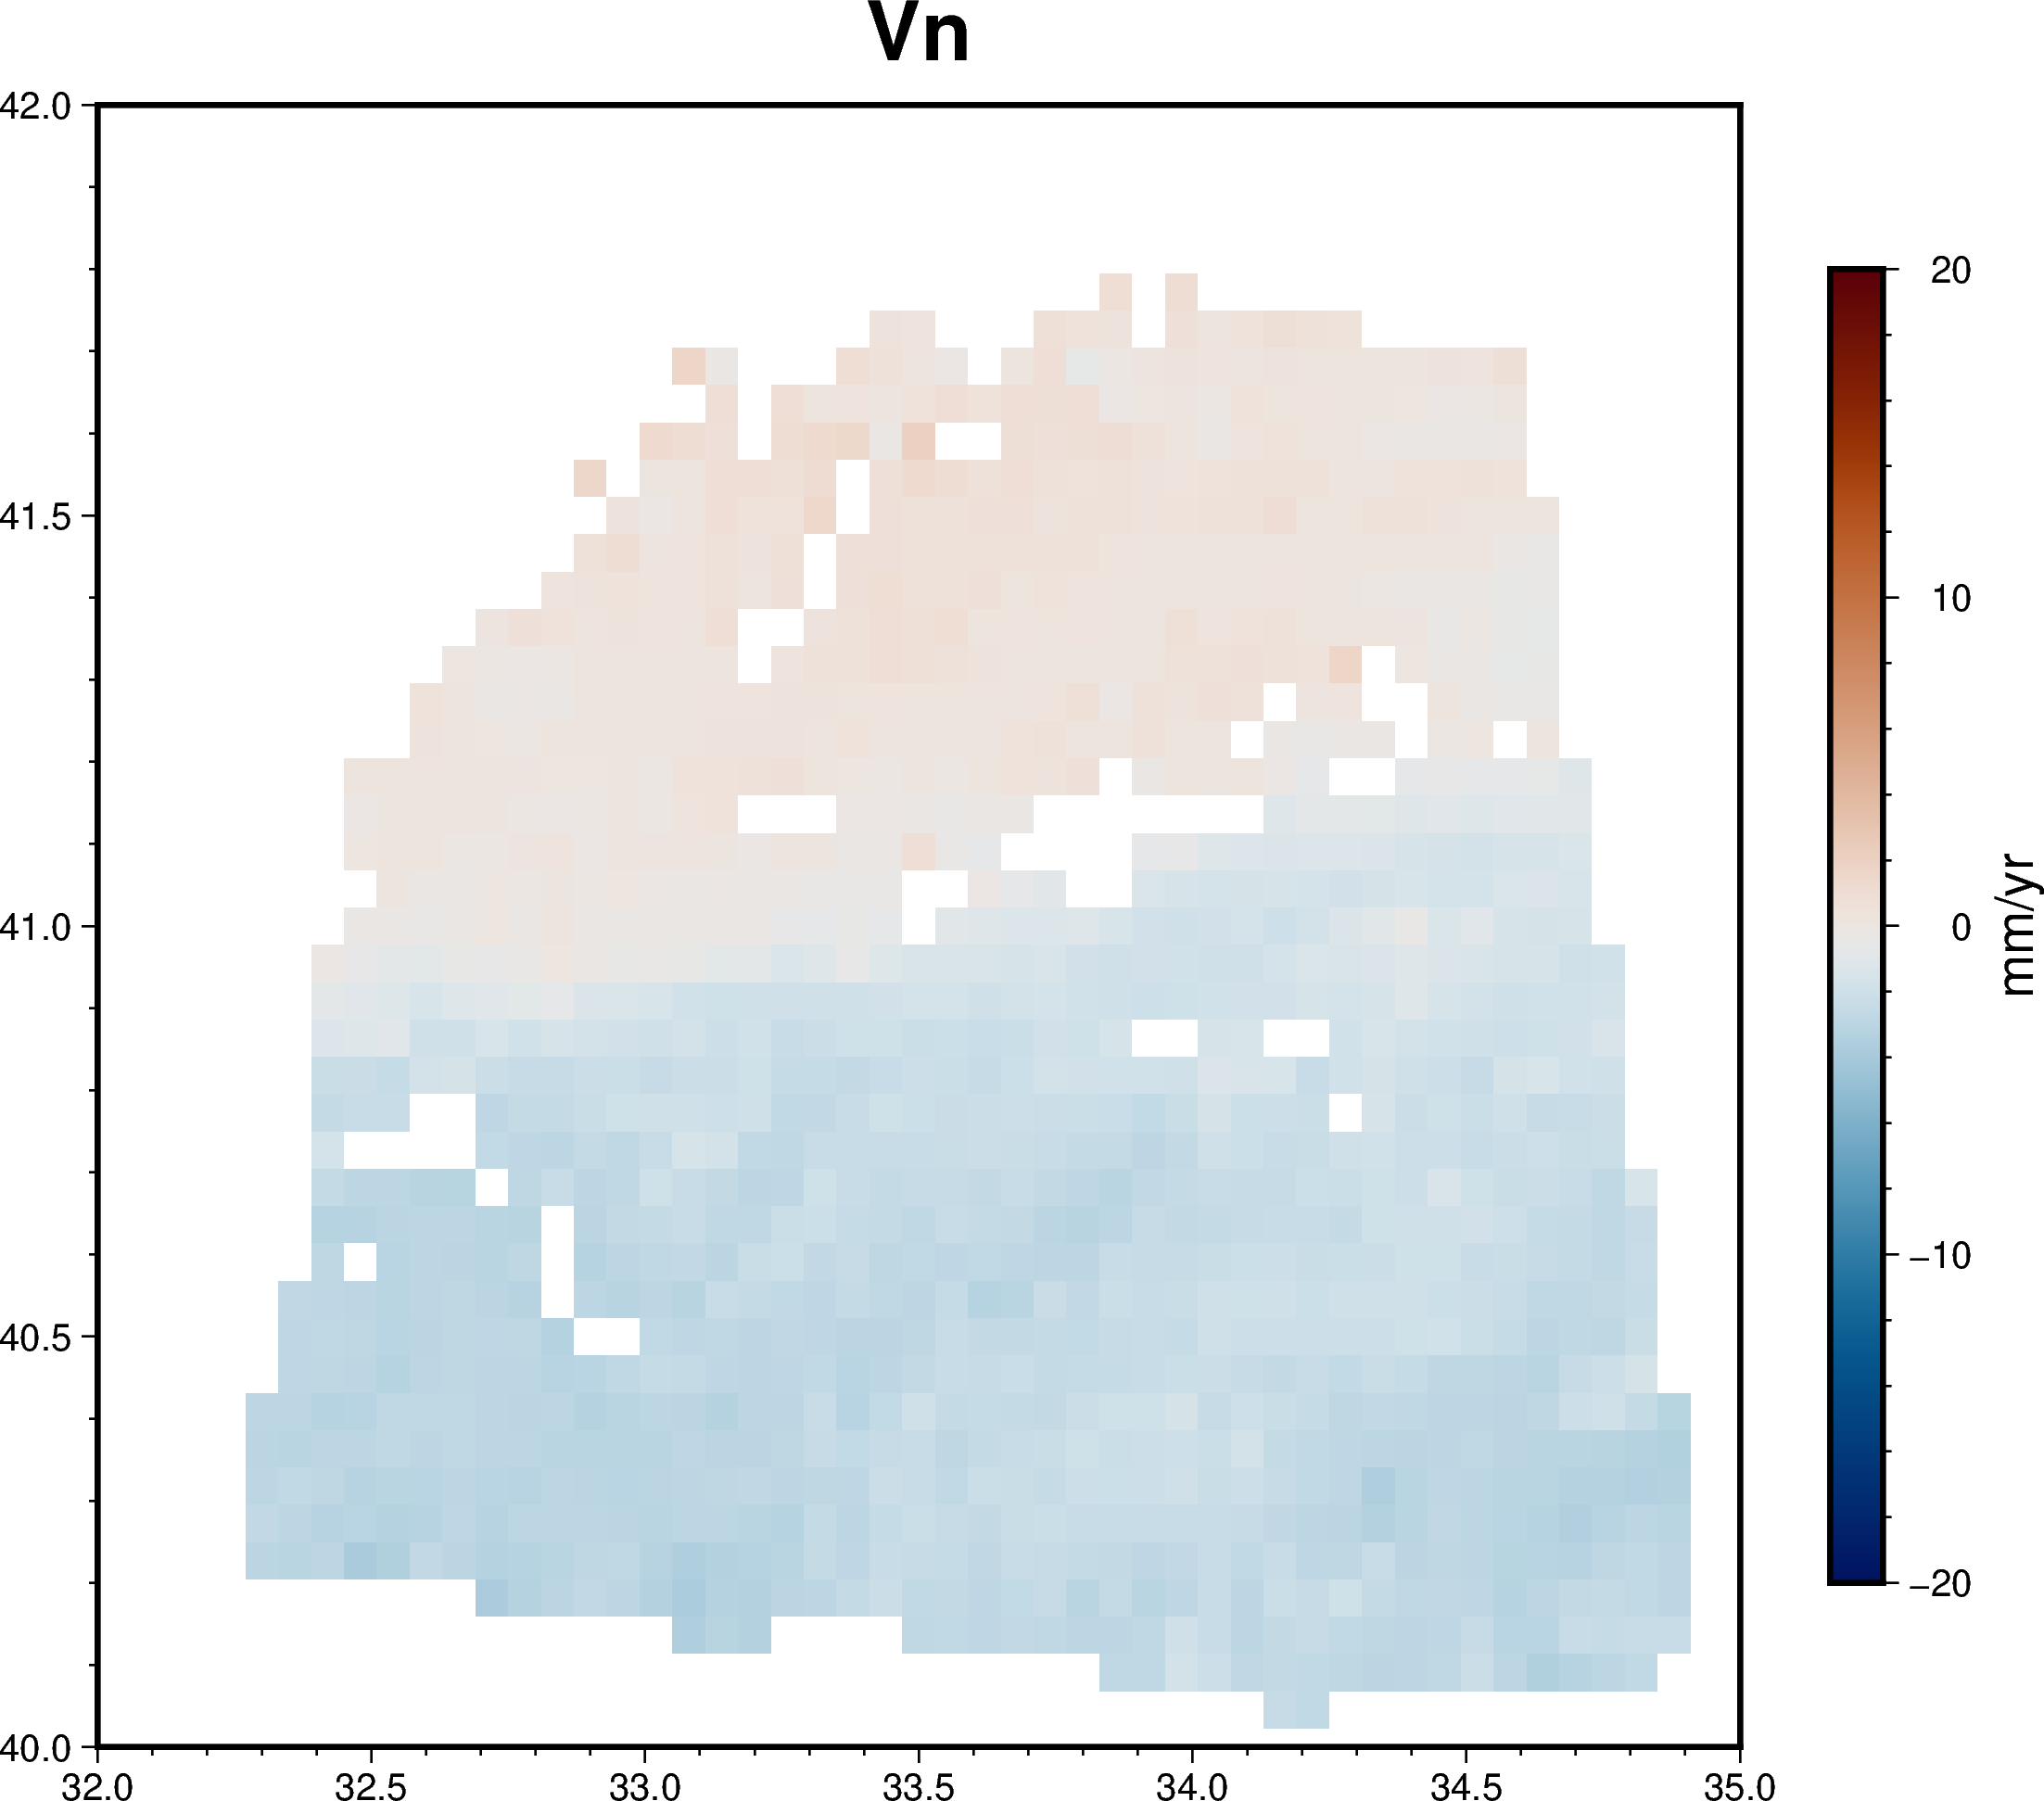

NameError: name 'grdmath' is not defined

In [114]:
# calculate Ve and Vn
vel_east = strike_E * vel_para_median_grd
vel_north = strike_N * vel_para_median_grd

# plot ve
fig = pygmt.Figure()
pygmt.makecpt(cmap="vik", series=[-20, 20])
fig.grdimage(
    grid=vel_east,
    region=region,
    frame=["af", '+t"Ve"'],
)
fig.colorbar(position="JMR", frame=["x+lmm/yr"])
fig.shift_origin(xshift="w+5c")
fig.show()

# plot vn
fig = pygmt.Figure()
pygmt.makecpt(cmap="vik", series=[-20, 20])
fig.grdimage(
    grid=vel_north,
    region=region,
    frame=["af", '+t"Vn"'],
)
fig.colorbar(position="JMR", frame=["x+lmm/yr"])
fig.show()

# calculate velocity gradients
dVedy = (vel_east[1:]-vel_east[:-1]) / 5 / 10**6  # mm/yr velocity difference divided by 5 km spacing
dVedx = (vel_east[:,1:]-vel_east[:,:-1]) / 5 / 10**6  
dVndy = (vel_north[1:]-vel_north[:-1]) / 5 / 10**6  # mm/yr velocity difference divided by 5 km spacing
dVndx = (vel_north[:,1:]-vel_north[:,:-1]) / 5 / 10**6  

# calculate elements of a 2x2 horizontal strain tensor 
exx = dVedx
eyy = dVndy
exy = (dVedy+dVndx)/2

# calculate maximum shear 
shear = np.sqrt(exy**2 + ((exx-eyy)**2)/4) # in units of strain
shear = shear * 10**9 # in units of nanostrain

# plot maximum shear
fig = pygmt.Figure()
pygmt.makecpt(cmap="lajolla", series=[0, 20])
fig.grdimage(
    grid=shear,
    region=region,
    frame=["af", '+t"Maximum Shear"'],
)
fig.colorbar(position="JMR", frame=["x+lnst/yr"])
fig.show()

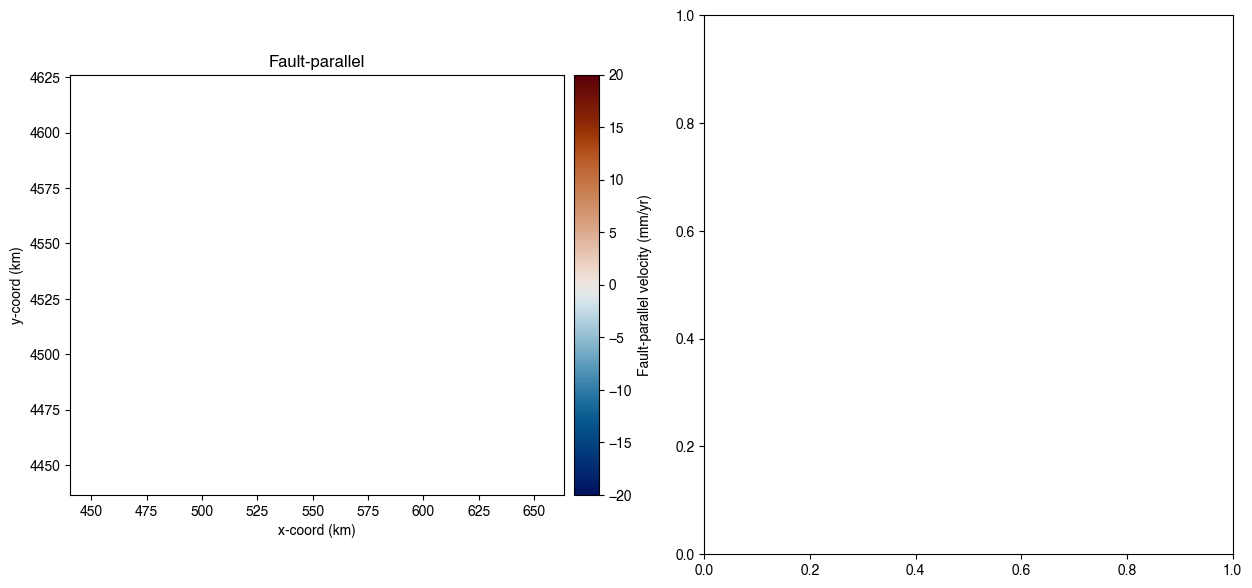

In [34]:
vel_para_median = pygmt.blockmedian(
    x=xx_regrid.flatten(), y=yy_regrid.flatten(), z=vel_para.flatten(), region="32/35/40/42", spacing="10k"
)
# plot the results
fig, axs = plt.subplots(1,2,figsize=(15,10))

# East velocities
im = axs[0].imshow(vel_para_median, extent=[32, 35, 40, 42], \
                   cmap=cm.vik, vmin=-20, vmax=20)
axs[0].plot(fault_trace[:,0], fault_trace[:,1], color="red")
axs[0].plot(poly_asc[:,0], poly_asc[:,1], color="black", linestyle='dashed')
axs[0].plot(poly_desc[:,0], poly_desc[:,1], color="black", linestyle='dashed')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='Fault-parallel velocity (mm/yr)')
axs[0].set_title('Fault-parallel')
axs[0].set_xlim(np.amin(lon_regrid), np.amax(lon_regrid))
axs[0].set_ylim(np.amin(lat_regrid), np.amax(lat_regrid))

# # Up velocities
# im = axs[1].imshow(vel_U, extent=[lon_regrid[0], lon_regrid[-1], lat_regrid[0], lat_regrid[-1]], \
#                    cmap=cm.vik, vmin=-20, vmax=20)
# axs[1].plot(fault_trace[:,0], fault_trace[:,1], color="red")
# axs[1].plot(poly_asc[:,0], poly_asc[:,1], color="black", linestyle='dashed')
# axs[1].plot(poly_desc[:,0], poly_desc[:,1], color="black", linestyle='dashed')
# divider = make_axes_locatable(axs[1])
# cax = divider.append_axes("right", size="5%", pad="2%")
# plt.colorbar(im, cax=cax, label='Vertical velocity (mm/yr)')
# axs[1].set_title('Up')
# axs[1].set_xlim(np.amin(lon_regrid), np.amax(lon_regrid))
# axs[1].set_ylim(np.amin(lat_regrid), np.amax(lat_regrid))

# plt.tight_layout(w_pad=3)
plt.show()

0      33.996387
1      33.106388
2      33.436387
3      33.696387
4      33.826387
         ...    
347    34.406387
348    34.526386
349    34.626386
350    34.776386
351    34.846386
Name: 0, Length: 352, dtype: float64

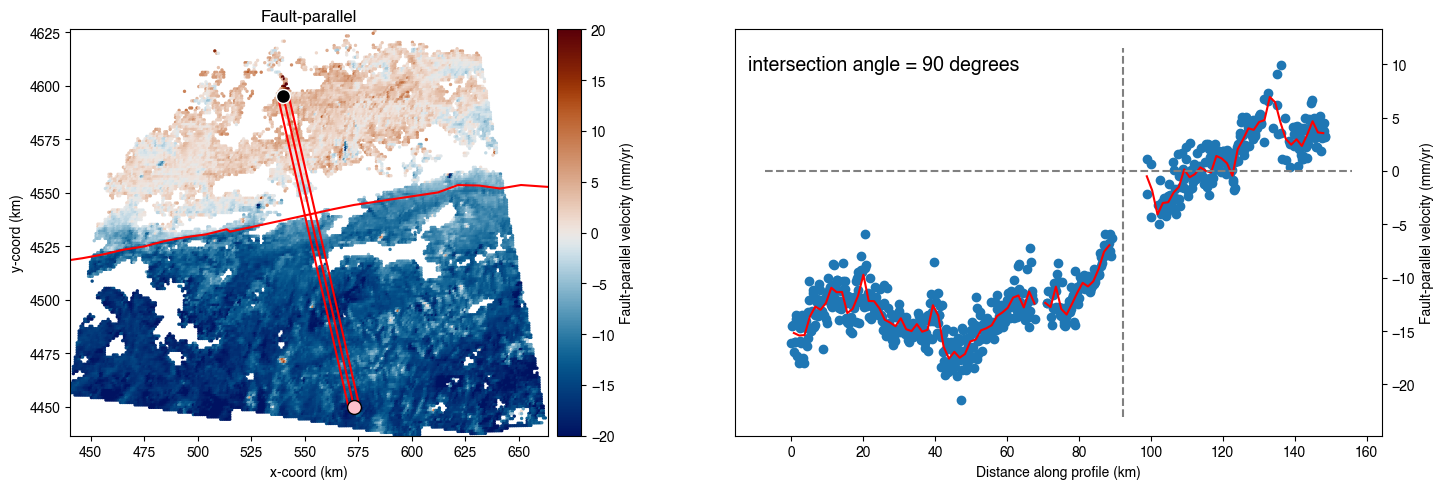

In [13]:
# Set the profile parameters

# rough middle profile
#####################################
prof_start = (573, 4450)
prof_end = (540, 4595)
prof_params = {
    "nbins": 100, # number of bins to split the profile into
    "width": 5  # total width of the profile in km
}
#####################################

# run the profiler
bin_val, prof_bin_mids, points_val, points_dist, points_poly \
    = lib.profile_data(xx_utm,yy_utm,vel_para,prof_start,prof_end,prof_params)

# calculate profile-fault intersection angle
intersect_dist, intersect_angle = lib.profile_fault_intersection(prof_start,prof_end,fault_trace_utm)

# plot
fig, axs = plt.subplots(1,2,figsize=(15,5))

# East velocities
im = axs[0].scatter(xx_utm.flatten(), yy_utm.flatten(), s=2, c=vel_para.flatten(), cmap=cm.vik, vmin=-20, vmax=20)
axs[0].plot(fault_trace_utm[:,0], fault_trace_utm[:,1], color="red")
axs[0].plot([prof_start[0], prof_end[0]], [prof_start[1], prof_end[1]], color="red")
axs[0].plot(points_poly[:,0],points_poly[:,1], color="red")
axs[0].scatter(prof_start[0],prof_start[1], s=100, color='pink', edgecolor='black', zorder=3)
axs[0].scatter(prof_end[0],prof_end[1], s=100, color='black', edgecolor='white', zorder=3)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='Fault-parallel velocity (mm/yr)')
axs[0].set_aspect('equal', 'box')
axs[0].set_title('Fault-parallel')
axs[0].set_xlabel('x-coord (km)')
axs[0].set_ylabel('y-coord (km)')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

# profile
axs[1].scatter(points_dist,points_val)
axs[1].plot(prof_bin_mids,bin_val,color="red")
axs[1].plot([intersect_dist, intersect_dist],[axs[1].get_ylim()[0], axs[1].get_ylim()[1]], color='grey', linestyle='dashed')
axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]], [0, 0], color='grey', linestyle='dashed')
axs[1].text(0.02, 0.90, 'intersection angle = ' + str(round(np.abs(intersect_angle))) + ' degrees', fontsize=14, transform = axs[1].transAxes)
axs[1].set_xlabel("Distance along profile (km)")
axs[1].set_ylabel("Fault-parallel velocity (mm/yr)")
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

fig.tight_layout(w_pad=4)
plt.show()

I've included the intersection angle between the fault and the profile line on the right-hand plot.
We want this angle to be 90&deg;, otherwise the signal will become smeared and effect our results.

## 5. Forward model

Now that we have our data, let's produce a simple forward model to get an idea of what model parameters produce a reasonable fit.

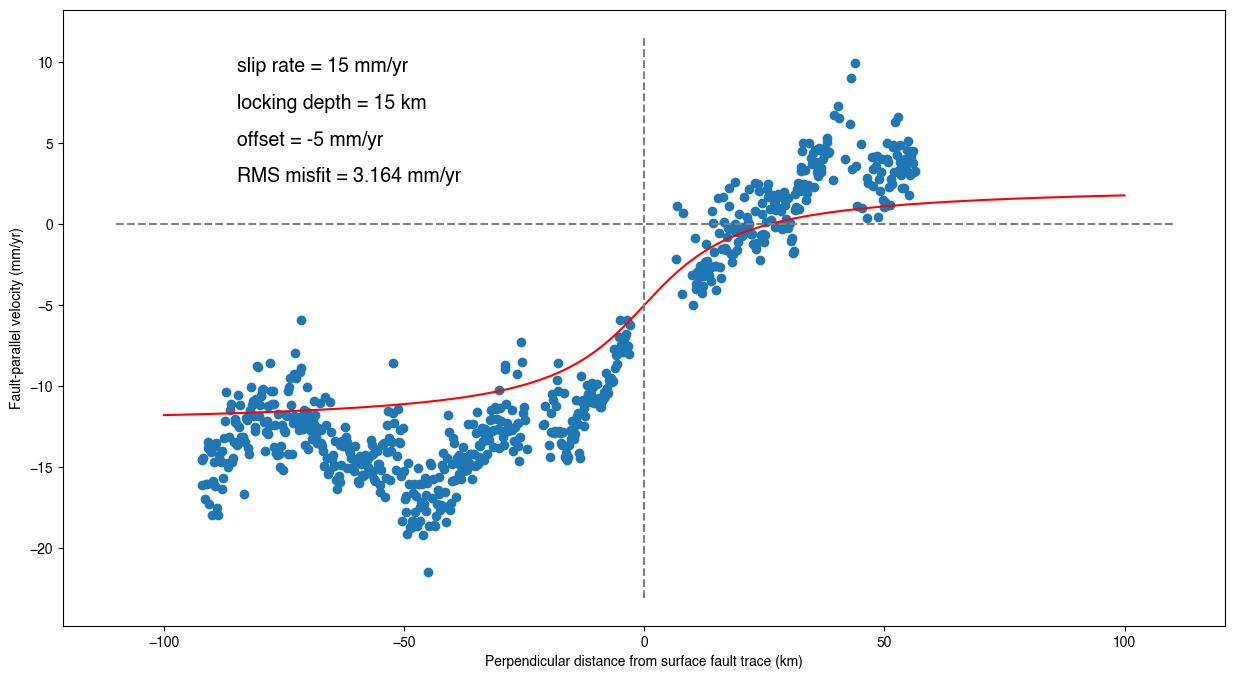

In [14]:
# Slip, locking depth, and offset
#####################################
s = 15 # mm/yr
d = 15 # km
c = -5 # mm/yr
#####################################

# shift profile so that the fault is at 0 km
x_prof = points_dist - intersect_dist

# Vector of positions every 1 km for -100 km to 100 km
x = np.arange(-100,101,1)

# run the forward model
v = lib.screw_disc(x*1000, s/1000, d*1000, c/1000)

# calculate rms misfit by running the forward model for x positions with velocities
v_forward = lib.screw_disc(x_prof*1000, s/1000, d*1000, c/1000)
rms_forward = lib.rms_misfit(points_val,v_forward*1000)

# Plot comparison
fig, axs = plt.subplots(1,1,figsize=(15,8))

plt.scatter(x_prof,points_val)
plt.plot(x, v*1000, c='r')
plt.plot([0, 0],[axs.get_ylim()[0], axs.get_ylim()[1]], color='grey', linestyle='dashed')
plt.plot([axs.get_xlim()[0], axs.get_xlim()[1]], [0, 0], color='grey', linestyle='dashed')

plt.text(0.15, 0.9, 'slip rate = ' + str(s) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.84, 'locking depth = ' + str(d) + ' km', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.78, 'offset = ' + str(c) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.72, 'RMS misfit = ' + str(round(rms_forward,3)) + ' mm/yr', fontsize=14, transform = axs.transAxes)

plt.xlabel('Perpendicular distance from surface fault trace (km)')
plt.ylabel('Fault-parallel velocity (mm/yr)')

plt.show()

To see how well you can all model the fault, lets model the same profile and then share the results.

Set your profile to the following:
```
prof_start = (573, 4450)
prof_end = (540, 4595)
```

Once you have your best model, let me know your parameter values.

## 6. Bayesian inversion

Bayesian inversions are one way we can estimate model parameters and their uncertainties in geophysics. We take some prior knowledge about the model (e.g. limits of the model parameter values) and combine this with a likelihood function based on the observations to estimate the posterior probability (i.e. the likelihood of our model parameters being the true values given the data). By exploring a range of model parameter values, we can build up a a posterior probability distribution which tells us both our "best fit" values, known as the "maximum a posteriori probability (MAP)" solution, and allows us to estimate the uncertainties on this solution.

We'll assume uniform priors for each model parameter, meaning all values between the upper and lower limits are equally likely. Values outside of these limits are "impossible" and will be rejected in our inversion.

We use the following limits for our uniform priors:
- $0 \leq s \leq 40$ mm/yr
- $1 \leq d \leq 50$ km
- $-10 \leq c \leq 10$ mm/yr

Assuming our errors are Gaussian, we can find the maximum likelihood by minimising the weighted difference between the observed velocities, $\mathbf d$, and the model velocities, $g(\mathbf{m})$:
\begin{equation}
    \sum (\mathbf d-g(\mathbf{m}))*W*(\mathbf d-g(\mathbf{m}))
\end{equation}
where $W$ contains the weight for every velocity. Weighting the data is useful when some velocities have larger errors than others. For simplicity, we'll assume a uniform uncertainty of 1 mm/yr (1 standard deviation) across all of our velocities.

In order to explore the posterior distribution (i.e. test a large number of model parameter values) we'll use a Markov Chain Monte Carlo (MCMC) method.
Our MCMC performs the following steps:
- Take a starting model and add a random step to each parameters.
- Test whether this new model is within the prior limits, rejecting the model if not.
- Calculate the likelihoods for both models.
- If the new model has a higher likelihood, then accept this model. Also accept a number of models that are worse to help the Monte Carlo explore the full parameter space.

We need to allow the MCMC to sometimes accept less likely models to avoid local minima. These are models that are good compared to the surrounding models (in the parameter space), but are not the true best model (called the global minima).

In [ ]:
importlib.reload(lib)
np.random.seed(1)

# inversion setup
#####################################
n_iterations = 10000 # don't go above this value of 10,000 in the practical
#####################################

# take profiled velocities and shift the fault to be at zero
x_prof = points_dist - intersect_dist
v_prof = points_val

# model params and their limits
m_start = np.array([5, 5, 0], dtype=np.double) # slip in mm/yr, locking depth in km
m_min = np.array([0, 1, -10], dtype=np.double)
m_max = np.array([40, 50, 10], dtype=np.double)

# variance-covariance matrix, currently 1 mm/yr uncertainties
vcm = np.eye(len(x_prof))

# convert all units to metres
x = x_prof * 1000
v = v_prof / 1000
m_start = m_start * np.array([0.001, 1000, 0.001])
m_min = m_min * np.array([0.001, 1000, 0.001])
m_max = m_max * np.array([0.001, 1000, 0.001])
vcm = vcm / 1e6

# inversion setup
burn_in = round(n_iterations/100)
acceptance_coef = 0.001

# weightings
W = np.linalg.inv(vcm)

# pre-allocate arrays
models_saved=np.zeros((n_iterations,len(m_start))) * np.nan
ll_saved=np.zeros((n_iterations,1)) * np.nan
n_accept = 0 # number of accepted models
n_reject = 0 # number of rejected models

# pass starting model to current model
m_current = m_start.copy()

# run inversion
for ii in range(n_iterations):
    
    # propose model using different step sizes for each parameter
    m_trial = m_current.copy()
    m_trial[0] = m_trial[0] + np.random.normal(loc=0, scale=2.5, size=1)/1000 # slip rate
    m_trial[1] = m_trial[1] + np.random.normal(loc=0, scale=2.5, size=1)*1000 # locking depth
    m_trial[2] = m_trial[2] + np.random.normal(loc=0, scale=1, size=1)/1000 # offset
    
    # check limits and skip the rest of the loop if any parameter is invalid
    if not(lib.prior(m_trial,m_min,m_max)):
        n_reject += 1
        models_saved[ii,:] = m_current
        continue
    
    # calculate likelihood for the current and trial models
    ll_current = lib.likelihood(x, v, m_current, W)
    ll_trial = lib.likelihood(x, v, m_trial, W)
    
    # test whether to keep trial model
    #if np.exp(acceptance_coef*(ll_trial-ll_current)) > np.random.uniform(low=0, high=1,size=1):
    if np.exp(acceptance_coef*(ll_current-ll_trial)) > np.random.uniform(low=0, high=1,size=1):
        m_current = m_trial
        ll_current = ll_trial
        n_accept += 1
    else:
        n_reject += 1
    models_saved[ii,:] = m_current
    ll_saved[ii] = ll_current
    
# convert back from metres to mm/yr and km
models_saved[:,0] = models_saved[:,0] * 1000 # slip rate
models_saved[:,1] = models_saved[:,1] / 1000 # locking depth
models_saved[:,2] = models_saved[:,2] * 1000 # offset

# find best fit model using min of likelihood function
best_model = models_saved[np.nanargmin(ll_saved),:]

print('Inversion complete')
print('Number of accepted models = ' + str(n_accept))
print('Number of rejected models = ' + str(n_reject))

First, we'll plot the accepted trial models for the slip rate and locking depth to see how the algorithm explores the parameter space.
We'll show the first 1% of iterations in red and the rest in blue.
These early iterations are often termed a "burn-in" period, where the inversion is moving from the start position towards the (global) minimum, which it then begins to explore.

In [ ]:
# plot walker 
plt.figure()
plt.plot(models_saved[:burn_in,0], models_saved[:burn_in,1], color='red', alpha=0.3)
plt.plot(models_saved[burn_in:,0], models_saved[burn_in:,1], color='blue', alpha=0.3)
plt.xlabel('Slip rate (mm/yr)')
plt.ylabel('Locking depth (km)')

We can also look at how the inversion explored the parameter space by plotting the likelihood function value for each iteration. The lowest likelihood will be located within a minima, while the higher likelihoods throughout show the inversion accepting worse models to help it escape local minima.

In [ ]:
# plot likelihood value throughout monte carlo
fig, axs = plt.subplots(1,1,figsize=(15,8))

axs.scatter(np.arange(1,len(ll_saved)+1),ll_saved, s=3)
axs.set_xlabel('Number of iterations')
axs.set_ylabel('Weighted residual')

plt.show()

Next, lets plot our best model on top of the profiled velocities.

In [ ]:
# calculate rms misfit
v_final = lib.screw_disc(x_prof, best_model[0], best_model[1], best_model[2])
best_rms = lib.rms_misfit(v_prof,v_final)

# for plotting
x = np.arange(-100,101,1)
v_final_plot = lib.screw_disc(x, best_model[0], best_model[1], best_model[2])

# Plot comparison
fig, axs = plt.subplots(1,1,figsize=(15,8))

plt.scatter(x_prof,v_prof)
plt.plot(x, v_final_plot, c='r')
plt.plot([0, 0],[axs.get_ylim()[0], axs.get_ylim()[1]], color='grey', linestyle='dashed')

plt.text(0.15, 0.8, 'slip = ' + str(round(best_model[0],2)) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.74, 'locking depth = ' + str(round(best_model[1],2)) + ' km', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.68, 'offset = ' + str(round(best_model[2],2)) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.62, 'RMS misfit = ' + str(round(best_rms,3)) + ' mm/yr', fontsize=14, transform = axs.transAxes)

plt.xlabel('Perp. distance from fault (km)')
plt.ylabel('Fault-parallel velocity (mm/yr)')

plt.show()

Now we'll plot histograms for each model parameter. The overall shape of these histograms should be gaussian, although they may be skewed to one side. They may also be quite rough depending on the number of iterations that have been run. By fitting a gaussian to each histogram, we can estimate the standard deviation of each, which is a measure of the uncertainty on our estimates.

We'll plot the best model values as vertical red lines. These should roughly line up with the peaks of our histograms.

In [ ]:
# calculate mean and standard deviation for each parameter
gauss_s = stats.norm.fit(models_saved[burn_in:,0])
gauss_d = stats.norm.fit(models_saved[burn_in:,1])
gauss_c = stats.norm.fit(models_saved[burn_in:,2])

# create figure
fig, axs = plt.subplots(1, 3, figsize=(15,8))

# plot histograms
_, bins_s, _ = axs[0].hist(models_saved[burn_in:,0], bins=20, density=True)
_, bins_d, _ = axs[1].hist(models_saved[burn_in:,1], bins=20, density=True)
_, bins_c, _ = axs[2].hist(models_saved[burn_in:,2], bins=20, density=True)

# create gaussian fit lines
gauss_fit_s = stats.norm.pdf(bins_s, gauss_s[0], gauss_s[1])
gauss_fit_d = stats.norm.pdf(bins_d, gauss_d[0], gauss_d[1])
gauss_fit_c = stats.norm.pdf(bins_c, gauss_c[0], gauss_c[1])

# plot gaussian fits
axs[0].plot(bins_s, gauss_fit_s)
axs[1].plot(bins_d, gauss_fit_d)
axs[2].plot(bins_c, gauss_fit_c)

# label mean and sd
axs[0].text(0.02, 0.97, 'mean = ' + str(round(gauss_s[0],2)), fontsize=14, transform = axs[0].transAxes)
axs[0].text(0.02, 0.94, 'sd = ' + str(round(gauss_s[1],2)), fontsize=14, transform = axs[0].transAxes)
axs[1].text(0.02, 0.97, 'mean = ' + str(round(gauss_d[0],2)), fontsize=14, transform = axs[1].transAxes)
axs[1].text(0.02, 0.94, 'sd = ' + str(round(gauss_d[1],2)), fontsize=14, transform = axs[1].transAxes)
axs[2].text(0.02, 0.97, 'mean = ' + str(round(gauss_c[0],2)), fontsize=14, transform = axs[2].transAxes)
axs[2].text(0.02, 0.94, 'sd = ' + str(round(gauss_c[1],2)), fontsize=14, transform = axs[2].transAxes)

# plot best model values
axs[0].plot([best_model[0], best_model[0]],[0, axs[0].get_ylim()[1]], color="red")
axs[1].plot([best_model[1], best_model[1]],[0, axs[1].get_ylim()[1]], color="red")
axs[2].plot([best_model[2], best_model[2]],[0, axs[2].get_ylim()[1]], color="red")

axs[0].set_title('Slip rate', fontsize=16)
axs[1].set_title('Locking depth', fontsize=16)
axs[2].set_title('Offset', fontsize=16)

axs[0].set_xlabel('Slip rate (mm/yr)', fontsize=14)
axs[1].set_xlabel('Locking depth (km)', fontsize=14)
axs[2].set_xlabel('Offset (mm/yr)', fontsize=14)

fig.tight_layout()
plt.show()

As we saw in the "walker" plot, there is a trade off between slip rate and locking depth, with an increase in one producing an increase in the other.

Lets replot the histograms above while also show the distribution of each model parameter against the other. This should make correlations between model parameters clearer to see. We'll use the Seaborn package for this, as it has a pre-made function for generate these multivariate plots. Its well worth an investigate if you want to use python to plot more scientific data in future.

In [ ]:
# This plot can take a couple minutes to run (dependent on the number of iterations)

# multivariate plot
models_df = pd.DataFrame(data=models_saved, columns=["Slip rate (mm/yr)", "Locking depth (km)", "Offset (mm/yr)"])
g = sns.PairGrid(models_df, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.kdeplot) # use this to plot as contours instead (runs slower)
g.fig.set_size_inches(13,13)

# add red dots for our best model
g.axes[1,0].scatter(best_model[0], best_model[1], c='red')
g.axes[2,0].scatter(best_model[0], best_model[2], c='red')
g.axes[2,1].scatter(best_model[1], best_model[2], c='red')

plt.show()

In [ ]:
# compare just slip rate and locking depth
models_df = pd.DataFrame(data=models_saved[:,0:2], columns=["Slip rate (mm/yr)", "Locking depth (km)"])
ax = sns.jointplot(data=models_df, x="Slip rate (mm/yr)", y="Locking depth (km)", kind="hex", height=8)
plt.show()

## 7. Extension - Fault creep

So far we've assumed that the NAF is locked from the surface down to a given depth, below which the fault is slipping aseismically. This gives a fault-parallel velocity of zero at the fault trace. Depending on where you have drawn your profile lines so far, you may have noticed a step in the velocities across the fault that is larger than the noise level. This may be fault creep, where the fault is also slipping aseismically at a shallow depth up to the surface. This fault creep occurs alongside the deeper interseismic slip.

A schematic diagram of fault creep is shown in Figure 5.

<img src="figures/faultCreep.png" style="float: centre;" width="500"/>

*Figure 5: (a) Schematic diagram of our fault creep model. (b) Forward model showing how the fault creep is expected to change our observed signal. From Hussian et al. (2016).*

We can model a combination of interseismic strain accumulation and fault creep to calculate a fault parallel velocity, $v$, at fault-perpendicular distance, $x$, using Equation 4:

\begin{equation}
v(x) = -\frac{s}{\pi}arctan\left(\frac{x+x_c}{d_1}\right) + C\left[\frac{1}{\pi}arctan\left(\frac{x+x_c}{d_2}\right) - H(x+x_c)\right] + c \qquad \qquad (4)
\end{equation}

We retain the screw dislocation model from before, where slip, $s$ occurs below a depth, $d_1$. For the shallow creep, occuring at a rate of $C$ between the surface and depth $d_2$, we use a back slip approach. This models the creep as the sum of slip on the entire fault plane using a Heaviside function ($H$) plus a screw dislocation in the opposite sense to the plate motion at depth $d_2$. We also retain the static offset, $c$, and include a new offset to the fault location, $x_c$. Sometimes the observed signal may not exactly align with the mapped fault trace, and so it can be useful to include a small offset to the location of the fault.

Let's take a new profile across a creeping part of the NAF.

In [ ]:
# creep
prof_start = (508, 4450)
prof_end = (480, 4620)

prof_params = {
    "nbins": 100, # number of bins to split the profile into
    "width": 5  # total width of the profile in km
}

# run the profiler
bin_val, prof_bin_mids, points_val, points_dist, points_poly \
    = lib.profile_data(xx_utm,yy_utm,vel_para,prof_start,prof_end,prof_params)

# calculate profile-fault intersection angle
intersect_dist, intersect_angle = lib.profile_fault_intersection(prof_start,prof_end,fault_trace_utm)

# plot
fig, axs = plt.subplots(1,2,figsize=(15,5))

# East velocities
im = axs[0].scatter(xx_utm.flatten(), yy_utm.flatten(), s=2, c=vel_para.flatten(), cmap=cm.vik, vmin=-20, vmax=20)
axs[0].plot(fault_trace_utm[:,0], fault_trace_utm[:,1], color="red")
axs[0].plot([prof_start[0], prof_end[0]], [prof_start[1], prof_end[1]], color="red")
axs[0].plot(points_poly[:,0],points_poly[:,1], color="red")
axs[0].scatter(prof_start[0],prof_start[1], color='red')
axs[0].scatter(prof_end[0],prof_end[1], color='black')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="2%")
plt.colorbar(im, cax=cax, label='Fault-parallel velocity (mm/yr)')
axs[0].set_aspect('equal', 'box')
axs[0].set_title('Fault-parallel')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

# profile
axs[1].scatter(points_dist,points_val)
axs[1].plot(prof_bin_mids,bin_val,color="red")
axs[1].plot([intersect_dist, intersect_dist],[axs[1].get_ylim()[0], axs[1].get_ylim()[1]], color='grey', linestyle='dashed')
axs[1].text(0.02, 0.90, 'intersection angle = ' + str(round(np.abs(intersect_angle))) + ' degrees', fontsize=14, transform = axs[1].transAxes)
axs[1].set_xlabel("Distance")
axs[1].set_ylabel("Fault-parallel velocity (mm/yr)")
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

plt.tight_layout(w_pad=4)
plt.show()

Next, we'll run a forward model.

In [ ]:
# Slip and locking depth
#####################################
s1 = 20 # mm/yr
s2 = 7 # mm/yr
d1 = 15 # km
d2 = 5 # km
c = -7 # mm/yr
xc = 0 # km
#####################################

# shift profile so thast fault is at 0 km
x_prof = points_dist - intersect_dist

# Vector of positions every 1 km for -100 km to 100 km
x = np.arange(-80,81,0.1)

# run the forward model
v = lib.fault_creep(x*1000, s1/1000, s2/1000, d1*1000, d2*1000, c/1000, xc=xc*1000)

# calculate rms misfit by running the forward model for x positions with velocities
v_forward = lib.fault_creep(x_prof*1000, s1/1000, s2/1000, d1*1000, d2*1000, c/1000, xc=xc*1000)
rms_forward = lib.rms_misfit(points_val,v_forward*1000)

# Plot comparison
fig, axs = plt.subplots(1,1,figsize=(15,8))

plt.scatter(x_prof,points_val)
plt.plot(x, v*1000, c='r')
plt.plot([0, 0],[axs.get_ylim()[0], axs.get_ylim()[1]], color='grey', linestyle='dashed')

plt.text(0.02, 0.9, 'slip = ' + str(s1) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.25, 0.9, 'creep = ' + str(s2) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.02, 0.84, 'locking depth = ' + str(d1) + ' km', fontsize=14, transform = axs.transAxes)
plt.text(0.25, 0.84, 'creep depth = ' + str(d2) + ' km', fontsize=14, transform = axs.transAxes)
plt.text(0.02, 0.78, 'offset = ' + str(c) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.02, 0.65, 'RMS misfit = ' + str(round(rms_forward,3)) + ' mm/yr', fontsize=14, transform = axs.transAxes)

plt.xlabel('Perp. distance from fault (km)')
plt.ylabel('Fault-parallel velocity (mm/yr)')

plt.show()

## 8. Extension - Strain Rate

Estimates of strain rate can highligh areas of concentrated deformation, an important product for understanding both seismic hazard the wider-scale kinematics. The state of strain in the lithosphere can be described using a strain rate tensor, $\dot{\varepsilon}$:

\begin{equation}
    \dot{\varepsilon} = \begin{bmatrix}
    \frac{\partial V_E}{\partial x} & \frac{1}{2}\left(\frac{\partial V_E}{\partial y}+\frac{\partial V_N}{\partial x}\right) & \frac{1}{2}\left(\frac{\partial V_E}{\partial z}+\frac{\partial V_U}{\partial x}\right) \\    
    \frac{1}{2}\left(\frac{\partial V_N}{\partial x}+\frac{\partial V_E}{\partial y}\right) & \frac{\partial V_N}{\partial y} & \frac{1}{2}\left(\frac{\partial V_N}{\partial z}+\frac{\partial V_U}{\partial y}\right) \\    
    \frac{1}{2}\left(\frac{\partial V_U}{\partial x}+\frac{\partial V_E}{\partial z}\right) & \frac{1}{2}\left(\frac{\partial V_U}{\partial y}+\frac{\partial V_N}{\partial z}\right) & \frac{\partial V_U}{\partial z}    
    \end{bmatrix} \qquad \qquad (5)
\end{equation}

where $v_E$, $v_N$, and $v_U$ are the velocities in the Cartesian coordinate direction, $x$, $y$, and $z$.

In this instance, we have fault-parellel velocities at distances perpendicular to the fault, and so we can only estimate the shear strain across the fault. For our screw dislocation model, we can forward model the shear strain, $e_{shear}$, using (Savage & Burford, 1973):

\begin{equation}
e_{shear} = \left(\frac{sd}{2\pi}\right)\left(x^2+d^2\right)^{-1} \qquad \qquad (6)
\end{equation}

Let's start by calculating the shear rate for the screw dislocation model that we fit to our original profile, using both a forward model (Equation 6) and by calculating the gradient in the modelled velocities.

In [ ]:
# Slip rate and locking depth
#####################################
s = 19 # mm/yr
d = 11 # km
c = -5.7 # mm/yr
#####################################

# Original profile line
prof_start = (573, 4450)
prof_end = (540, 4595)
prof_params = {
    "nbins": 100, # number of bins to split the profile into
    "width": 5  # total width of the profile in km
}

# run the profiler
bin_val, prof_bin_mids, points_val, points_dist, points_poly \
    = lib.profile_data(xx_utm,yy_utm,vel_para,prof_start,prof_end,prof_params)

# calculate profile-fault intersection angle
intersect_dist, intersect_angle = lib.profile_fault_intersection(prof_start,prof_end,fault_trace_utm)

# shift profile so that the fault is at 0 km
x_prof = points_dist - intersect_dist

# Vector of positions every 1 km for -100 km to 100 km
x = np.arange(-100,101,1)

# run the forward model
v = lib.screw_disc(x*1000, s/1000, d*1000, c/1000)

# calculate shear strain rate using Equation 6
e_shear = lib.shear_strain(x*1000, s/1000, d*1000)

# also calculate shear strain rate based purely on velocity gradient
e_shear_grad = np.gradient(v,x*1000)

# Plot the original profile and model, and strain rate
fig, axs = plt.subplots(2,1,figsize=(15,15))

axs[0].scatter(x_prof, points_val)
axs[0].plot(x, v*1000, c='r')
axs[0].plot([0, 0],[axs[0].get_ylim()[0], axs[0].get_ylim()[1]], color='grey', linestyle='dashed')
axs[0].text(0.02, 0.90, 'intersection angle = ' + str(round(np.abs(intersect_angle))) + ' degrees', fontsize=14, transform = axs[0].transAxes)
axs[0].set_xlabel("Distance from fault (km)")
axs[0].set_ylabel("Fault-parallel velocity (mm/yr)")
axs[0].yaxis.set_label_position("right")
axs[0].yaxis.tick_right()

axs[1].plot(x, e_shear, c='r', label='Forward model')
axs[1].plot(x, e_shear_grad, c='b', label='Velocity gradient')
axs[1].plot([0, 0],[axs[1].get_ylim()[0], axs[1].get_ylim()[1]], color='grey', linestyle='dashed')
axs[1].legend(fontsize='x-large')
axs[1].set_xlabel("Distance from fault (km)")
axs[1].set_ylabel("Shear strain rate (/yr)")
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

We can get nice smooth estimates of strain rate from our screw dislocation models. In real studies, we often want to estimate strain rates directly from our velocities, as this will capture signals that are not represented in our model. However, we still require some degree of smoothing to suppress short-wavelength noise in the InSAR. This noise, while small compared to the tectonic signal, can cause large gradients between adjacent points that then drown out the underying tectonic strain rate.

Let's plot both the strain rate directly calculated from the binned profiled fault-parallel velocities, and one calculated from the same velocities but smoothed with a sliding window average. Try changing the size of the smoothing window.

In [ ]:
# Window size for smoothing, must be an odd number
#####################################
wind_size = 9
#####################################

# shift fault location to 0 km
x_prof = prof_bin_mids - intersect_dist

# calcualte gradient of original binned velocities
e_shear = np.gradient(bin_val/1000, x_prof*1000)

# apply a sliding mean window to smooth out some of the noise
x_smoothed, e_shear_smoothed = lib.sliding_window_mean(x_prof, bin_val, 11)

# calculated the gradient from the smoothed velocities
e_shear_smoothed = np.gradient(e_shear_smoothed/1000, x_smoothed*1000)

# Plot comparison
fig, axs = plt.subplots(1,1,figsize=(15,8))

plt.plot(x_prof, e_shear, c='r', label='Original binned velocities')
plt.plot(x_smoothed, e_shear_smoothed, c='b', label='Smoothed velocities')
plt.plot([0, 0],[axs.get_ylim()[0], axs.get_ylim()[1]], color='grey', linestyle='dashed')
plt.xlabel('Distance from fault (km)')
plt.ylabel('Shear strain rate (/yr)')
plt.legend(fontsize="x-large")

plt.show()

If we calculate the strain rate directly from the binned velocities (which have themselves already been smoothed to some degree), then the strain signal we would expect to see based on Equation 5 is completely masked.

By applying a smoothing window (a window size of 9 works quite well), we can bring out the higher strain across the fault trace. If the window size is increased too far, then we can actually smooth out the original interseismic signal, and this peak disappears again. How we filter out high-frequency noise in the velocities is integral to our estimates of strain rate.

For further reading, I recommend Weiss et al. (2020), who apply the Velmap method to all of Turkey, and Ou et al. (2022), who use a gaussian filter method to localise strain onto a number of faults in the Tibetan Plateau.

## Conclusion

Hopefully, you now have a basic understanding of how we measure and model interseismic deformation. This practical has been shared under an open-access licence (see repo), so feel free to pass it on and utilise any of the underlying code. 

If you are interested in performing velocity decompositions on a larger scale, have a look at our open-access Matlab package:
https://github.com/andwatson/decompose_insar_velocities

If you are interested in a more developed version of the bayesian inversion, have a look at both Hussain et al. (2016) and the GBIS inversion software, for interseismic and coseismic deformation, respectively:
https://comet.nerc.ac.uk/gbis/

If you found any issues in this practical, please log them under "issues" on the github repository.

Andrew Watson - 2022

### References

Elliott, J. (2009). Strain accumulation & release on the Tibetan Plateau measured using InSAR (Doctoral dissertation, Oxford University).

Hussain, E., Wright, T. J., Walters, R. J., Bekaert, D., Hooper, A., & Houseman, G. A. (2016). Geodetic observations of postseismic creep in the decade after the 1999 Izmit earthquake, Turkey: Implications for a shallow slip deficit. Journal of Geophysical Research: Solid Earth, 121(4), 2980-3001.

Ou, Q., Daout, S., Weiss, J. R., Shen, L., Lazecký, M., Wright, T. J., & Parsons, B. E. (2022). Large‐Scale Interseismic Strain Mapping of the NE Tibetan Plateau From Sentinel‐1 Interferometry. Journal of Geophysical Research: Solid Earth, 127(6), e2022JB024176.

Savage, J. C., & Burford, R. O. (1973). Geodetic determination of relative plate motion in central California. Journal of Geophysical Research, 78(5), 832-845.

Vernant, P. (2015). What can we learn from 20 years of interseismic GPS measurements across strike-slip faults?. Tectonophysics, 644, 22-39.

Weiss, J. R., et al. (2020). High‐resolution surface velocities and strain for Anatolia from Sentinel‐1 InSAR and GNSS data. Geophysical Research Letters, 47(17), e2020GL087376.